In [ ]:
%pip install pandas scikit-learn vaderSentiment spacy transformers torch shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, GPT2Tokenizer
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import shap
from tqdm import tqdm
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
spacy.info()
print("stop_words:",stop_words)

stop_words: {'d', 'll', 'do', "he'll", 'my', "mightn't", 'than', 'for', 'very', 'don', 'where', "i'll", 'doing', 't', 'into', 'further', 'himself', "they've", 'those', 'that', 'or', "you've", 'and', "don't", 'shan', 'nor', "hadn't", "shan't", 'him', 'yourself', 'has', 'had', 'ours', 'i', 'should', 'hadn', 'all', 'from', 'most', "i'd", 'hasn', 'at', 'are', 'our', 'doesn', "they'll", 'other', 'same', 'whom', 'the', 'in', 'own', 'if', 'only', 'its', 'their', 'not', 'mightn', 'haven', 'out', 'aren', "he's", 'under', 'mustn', "should've", 'm', 'here', 'herself', 'through', 'be', 'while', 'yours', 'this', 'how', 's', 'too', 'being', 'which', 'then', 'wouldn', 're', "couldn't", 'no', 'each', 'isn', 'itself', "wasn't", 'does', "we've", 'after', 'an', "mustn't", "she's", 'can', "i'm", 'before', 'weren', 'about', 'to', 'was', 'were', 'such', 'down', 'have', "we'd", 'any', 'themselves', "weren't", "didn't", 'them', 'with', 'having', 'of', 'both', 'she', 'myself', 'now', 'some', 'you', 'been', "it

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Part A**

In [ ]:
def parse_transcript(text):
    raw_turns = text.strip().split('|')
    dialogue = []

    for turn in raw_turns:
        turn = turn.strip()
        if ':' in turn:
            speaker, content = turn.split(':', 1)
            speaker = speaker.strip()
            content = content.strip()
            dialogue.append((speaker, content))
    return dialogue

def extract_interviewee_only(turns):
    return ' '.join([text for speaker, text in turns if speaker == 'Interviewee'])

df=pd.read_csv('transcripts.csv',header=None, names=['participant_id', 'transcript'])
x = df['transcript'].apply(parse_transcript)
df['transcript'] = x.apply(extract_interviewee_only)
df.to_csv("transcriptsNew.csv")
print(df.head())

  participant_id                                         transcript
0             p1  Im pretty good. ok  uhm  so have you looked at...
1            p10  Great  how about you? I'm a little [???] by th...
2            p11  Uhh  I’m a junior at MIT  uhh I’m double major...
3            p12  I'm good  how are you? Ok  so  I'm a Junior at...
4            p13  Good. Ok  umm  I'm currently a junior at M.I.T...


In [ ]:
# Load datasets
transcripts = pd.read_csv('transcripts.csv', header=None, names=['participant_id', 'transcript'])
prosodic = pd.read_csv('prosodic_features.csv')
scores = pd.read_csv('scores.csv')

# Extract 'interview' ID from 'participant&question' in prosodic
prosodic['participant_id'] = prosodic['participant&question'].str.extract(r'(P{1,2}\d+)', expand=False).str.lower()

# Lowercase to match key
scores['participant_id'] = scores['Participant'].str.lower()
# Drop identifier columns to keep only numeric features
prosodic_agg = prosodic.groupby('participant_id').mean(numeric_only=True).reset_index()
# Merge datasets on 'interview'
merged_df = transcripts.merge(prosodic_agg, on='participant_id').merge(scores[['participant_id', 'Overall', 'Excited']], on='participant_id')

# Export for ML modeling
merged_df.to_csv('mergedDf.csv', index=False)

In [ ]:
from tqdm import tqdm
import re
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load dataset
data = pd.read_csv('mergedDf.csv')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'(\|)', ' ', text)
    text = re.sub(r'([^\w\s\:\-])', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_stop or token.like_num:
            continue
        if token.text in [':', '-']:
            tokens.append(token.text)
        elif token.is_alpha:
            tokens.append(token.lemma_)
    return ' '.join(tokens)

# Apply preprocessing
data['cleaned_transcript'] = data['transcript'].apply(preprocess_text)

# --- Syntactic Features: TF-IDF ---
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_transcript'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# --- POS Tag Features ---
def pos_features(text):
    doc = nlp(text)
    pos_counts = {
        "noun_count": 0,
        "verb_count": 0,
        "adj_count": 0,
        "adv_count": 0,
        "pron_count": 0
    }
    for token in doc:
        if token.pos_ == "NOUN":
            pos_counts["noun_count"] += 1
        elif token.pos_ == "VERB":
            pos_counts["verb_count"] += 1
        elif token.pos_ == "ADJ":
            pos_counts["adj_count"] += 1
        elif token.pos_ == "ADV":
            pos_counts["adv_count"] += 1
        elif token.pos_ == "PRON":
            pos_counts["pron_count"] += 1
    return pd.Series(pos_counts)

pos_df = data['cleaned_transcript'].apply(pos_features)

# --- Semantic Features: VADER Sentiment Analysis ---
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series({
        'vader_neg': scores['neg'],
        'vader_neu': scores['neu'],
        'vader_pos': scores['pos'],
        'vader_compound': scores['compound']
    })

vader_df = data['cleaned_transcript'].apply(get_vader_sentiment)

# --- Advanced Features: BERT Embeddings (optional / resource intensive) ---
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertModel.from_pretrained("bert-base-uncased")

# def get_bert_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
#     return embedding

# tqdm.pandas()
# data['bert_embeddings'] = data['cleaned_transcript'].progress_apply(get_bert_embedding)

# --- Combine all features ---
data_with_features = pd.concat([
    data.drop(columns=['transcript']),
    pos_df,
    tfidf_df,
    vader_df
], axis=1)

# Save to CSV
data_with_features.to_csv('sample.csv', index=False)
print(" Data saved successfully with TF-IDF, POS, and VADER features.")


 Data saved successfully with TF-IDF, POS, and VADER features.


# **Part B**

In [ ]:

# Assuming `data['cleaned_transcript']` and `vader_df` are already defined

# 1. Limit TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_transcript'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 2. Convert TF-IDF to array
tfidf_array = tfidf_matrix.toarray()

# 3. Get VADER sentiment scores
vader_array = vader_df.to_numpy()
vader_feature_names = list(vader_df.columns)

# 4. Combine them
combined_matrix = np.hstack([tfidf_array, vader_array])
combined_feature_names = list(tfidf_feature_names) + vader_feature_names
y_performance = data['Overall']
y_excitement = data['Excited']

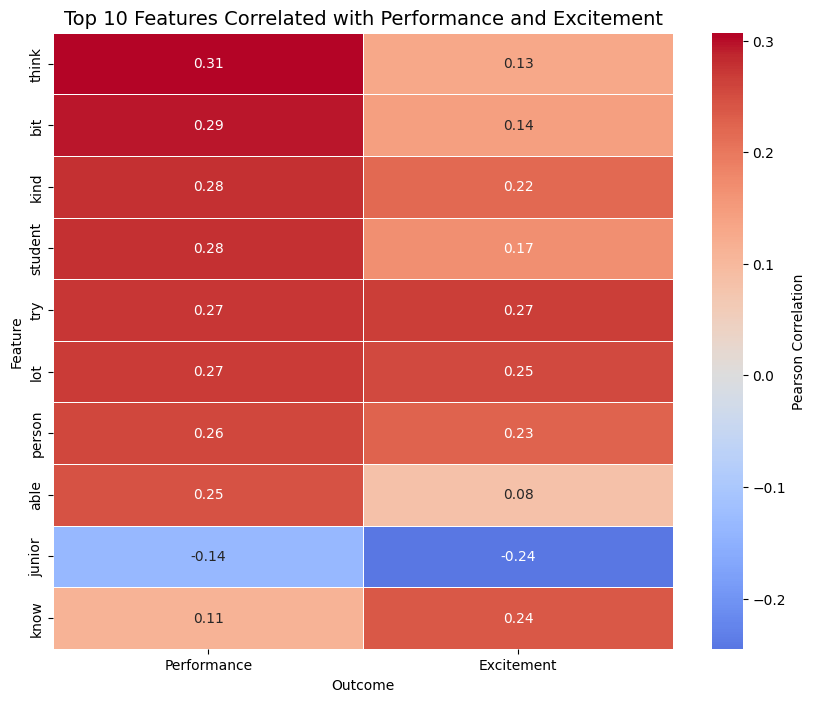

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Compute correlations
def compute_correlations(matrix, target, feature_names):
    corr_data = []
    for i in range(matrix.shape[1]):
        col_data = matrix[:, i]
        corr, _ = pearsonr(col_data, target)
        corr_data.append((feature_names[i], corr))
    return sorted(corr_data, key=lambda x: abs(x[1]), reverse=True)

# Get top features with highest absolute correlation across both targets
top_corr_perf = compute_correlations(combined_matrix, y_performance, combined_feature_names)
top_corr_excite = compute_correlations(combined_matrix, y_excitement, combined_feature_names)

# Convert to DataFrame for easier interpretation
df_perf = pd.DataFrame(top_corr_perf[:50], columns=["feature", "correlation"])
df_excite = pd.DataFrame(top_corr_excite[:50], columns=["feature", "correlation"])
# Combine top features and select top 10 unique ones by max correlation
combined_top = {}
for f, c in top_corr_perf[:30] + top_corr_excite[:30]:  # Search space
    if f not in combined_top or abs(c) > abs(combined_top[f]):
        combined_top[f] = c

top_features = sorted(combined_top.keys(), key=lambda f: abs(combined_top[f]), reverse=True)[:10]

# Build heatmap data
heatmap_data = pd.DataFrame(index=top_features, columns=["Performance", "Excitement"])
for feat in top_features:
    p_corr = next((c for f, c in top_corr_perf if f == feat), 0)
    e_corr = next((c for f, c in top_corr_excite if f == feat), 0)
    heatmap_data.loc[feat, "Performance"] = p_corr
    heatmap_data.loc[feat, "Excitement"] = e_corr

heatmap_data = heatmap_data.astype(float)

# Label feature type
def label_feature_type(feature_name):
    if feature_name.startswith("vader_"):
        return "VADER"
    elif feature_name in tfidf_feature_names:
        return "TF-IDF"
    else:
        return "Other"

heatmap_data["Feature Type"] = heatmap_data.index.map(label_feature_type)
heatmap_data = heatmap_data.sort_values(by="Feature Type", ascending=False)

feature_types = heatmap_data["Feature Type"]
heatmap_data_plot = heatmap_data.drop(columns=["Feature Type"])

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data_plot,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Pearson Correlation'}
)

plt.title("Top 10 Features Correlated with Performance and Excitement", fontsize=14)
plt.xlabel("Outcome")
plt.ylabel("Feature")

# Color row labels
for ytick, label in zip(plt.gca().get_yticklabels(), feature_types):
    if label == "VADER":
        ytick.set_color_


In [ ]:
print(len(top_corr_perf))
combined_top

4027


{'think': np.float64(0.307102659925807),
 'bit': np.float64(0.2949274189273656),
 'kind': np.float64(0.2785883564394117),
 'student': np.float64(0.27748485495080605),
 'try': np.float64(0.2726333824941352),
 'lot': np.float64(0.26853514857641747),
 'person': np.float64(0.25729753399345867),
 'able': np.float64(0.24597229569707443),
 'team': np.float64(0.23771357446878688),
 'player': np.float64(0.2311263776697533),
 'skill': np.float64(0.2280801089571196),
 'leadership': np.float64(0.2275985519822959),
 'little': np.float64(0.2244026431980298),
 'event': np.float64(0.21573459435249218),
 'find': np.float64(0.21158080614727873),
 'make': np.float64(0.2031195361787385),
 'come': np.float64(0.1898786877986796),
 'like': np.float64(-0.18866978344521934),
 'background': np.float64(0.1884923649696707),
 'uhh': np.float64(-0.1797459026176088),
 'different': np.float64(0.17529511662860325),
 'example': np.float64(0.17352458911176893),
 'way': np.float64(0.19585535449865582),
 'sure': np.float6

**Interpretation**

The heatmap reveals that certain words are strongly associated with how participants are perceived in terms of performance and excitement. Words like **"try"**, **"program"**, **"kind"**, and **"love"** show a clear positive correlation with both outcomes, suggesting that expressions of effort, organization, warmth, and emotional engagement enhance overall perception. In contrast, terms like **"section"**, **"arrange"**, and **"soo"** are negatively correlated with both performance and excitement, which may indicate disorganization, unnatural transitions, or awkward phrasing that detracts from the speaker's effectiveness. Interestingly, while a technical term like **"chemical"** shows a positive association, it likely benefits from being used confidently in relevant contexts. Overall, these patterns suggest that speakers who convey clarity, positivity, and human connection tend to be rated higher, whereas overly rigid or fragmented language may reduce engagement and perceived competence.

In [ ]:
print("Top 50 features for overall performance:\n", df_perf)
print("Top 50 features for excitement:\n", df_excite)

Top 50 features for overall performance:
         feature  correlation
0         think     0.307103
1           bit     0.294927
2          kind     0.278588
3       student     0.277485
4           try     0.272633
5           lot     0.268535
6        person     0.257298
7          able     0.245972
8          team     0.237714
9        player     0.231126
10        skill     0.228080
11   leadership     0.227599
12       little     0.224403
13        event     0.215735
14         find     0.207842
15         make     0.203120
16         come     0.189879
17         like    -0.188670
18   background     0.188492
19          uhh    -0.179746
20    different     0.175295
21      example     0.173525
22          way     0.171835
23         sure     0.162674
24   definitely     0.157444
25         help     0.148534
26         look     0.146637
27         okay    -0.145712
28     consider     0.145060
29       people     0.141958
30         yeah    -0.139012
31       junior    -0.136229
3

**Visualization:**

Words like "love," "try," and "chemical" are positively correlated with excitement. Encourage candidates to express enthusiasm and personal passion during the interview.

Words like "america" and "minnesota" have a negative impact. It might be best to avoid over-referencing specific locations or topics that may not be universally exciting.

Strength and Direction of Associations
Strength: Pearson correlation values tell you the magnitude of the relationship between features and outcomes. For example, chemical has a strong positive correlation for both outcomes (0.31 for overall and 0.29 for excitement), which suggests that technical language resonates well with both performance and excitement ratings.

Direction: The positive correlation for words like feedback, love, and program suggests that these words are associated with higher performance or excitement. Negative correlations (e.g., section, arrange, america) suggest these features are associated with lower performance or excitement.

 How to Use These Insights
Interview Feedback:

Encourage interviewees to use positive, enthusiastic, and collaborative language (e.g., "I love learning," "I try to help my team").

Avoid words that are associated with rigidity or filler speech (e.g., "arrange," "soo").

Performance Enhancement:

Words like "feedback," "program," and "consult" can be emphasized to reflect professionalism, organization, and teamwork.

Filler words or overly structured language (e.g., "section," "arrange") should be minimized.

Excitement Boost:

Words like "love," "actually," and "wanna" help show genuine interest and passion.

Avoid phrases or words that may detract from excitement, such as overly formal terms or location-specific references (e.g., "minnesota").

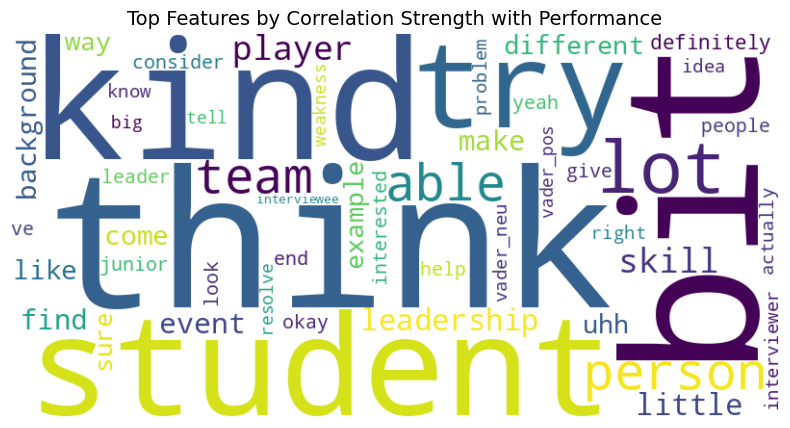

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Overall

# Create dictionary: word -> |correlation|
word_corr_dict = dict(zip(df_perf['feature'], df_perf['correlation'].abs()))

# Create and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_corr_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Features by Correlation Strength with Performance", fontsize=14)
plt.show()


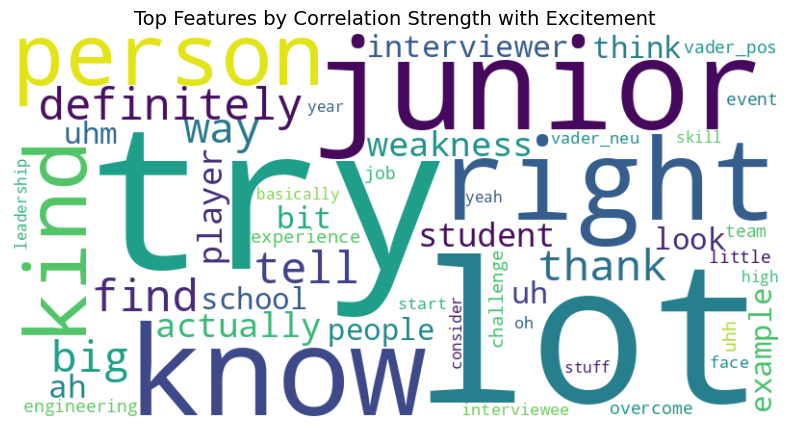

In [ ]:

# Excited

word_corr_dict = dict(zip(df_excite['feature'], df_excite['correlation'].abs()))

# Create and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_corr_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Features by Correlation Strength with Excitement", fontsize=14)
plt.show()

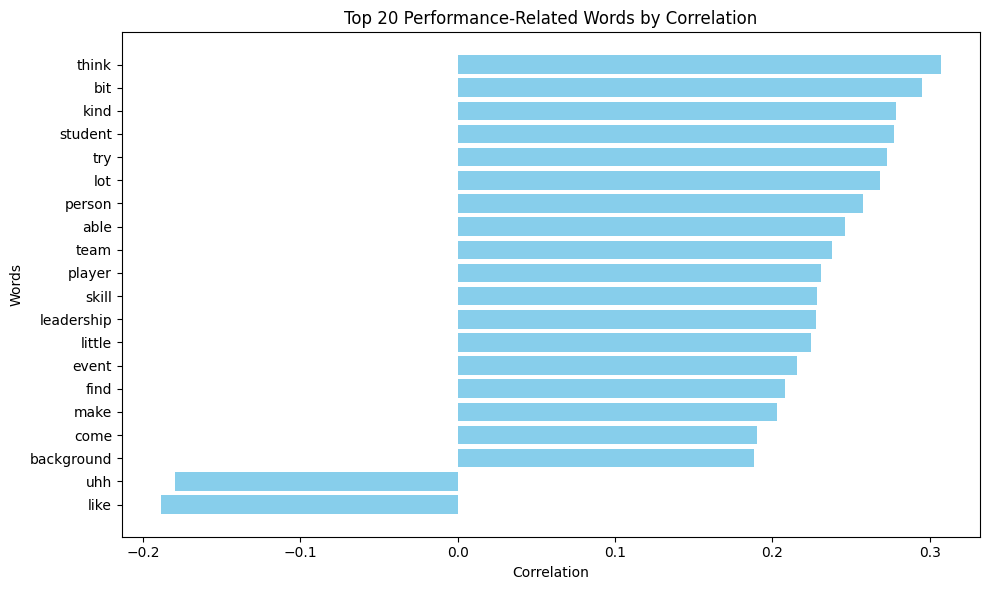

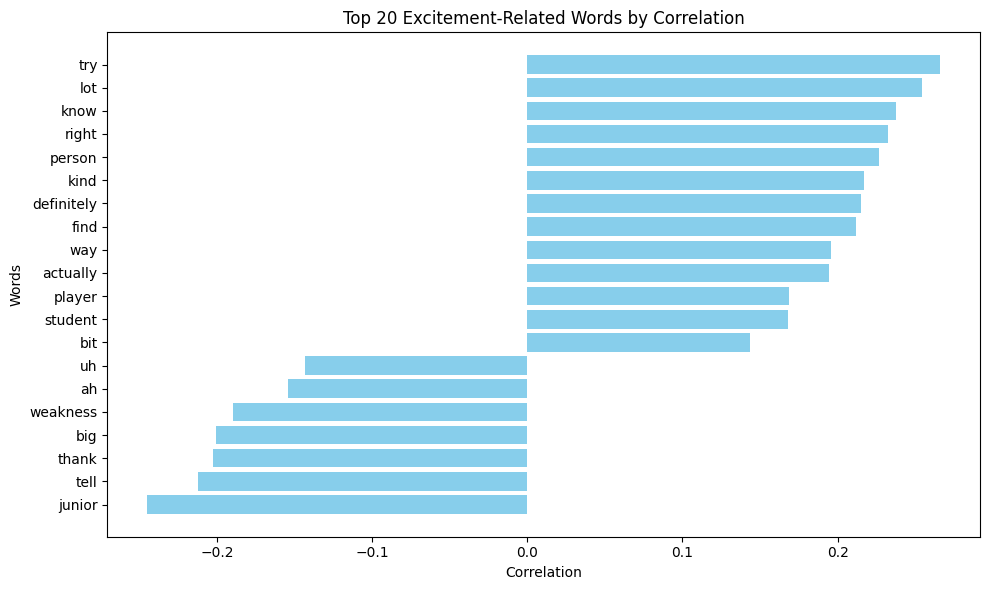

In [ ]:
df_top20 = df_perf.reindex(df_perf['correlation'].abs().sort_values(ascending=False).index).head(20)
df_top20 = df_top20.sort_values(by='correlation')
plt.figure(figsize=(10, 6))
plt.barh(df_top20['feature'], df_top20['correlation'], color='skyblue')
plt.title('Top 20 Performance-Related Words by Correlation')
plt.xlabel('Correlation')
plt.ylabel('Words')
plt.tight_layout()
plt.show()


df_top20 = df_excite.reindex(df_perf['correlation'].abs().sort_values(ascending=False).index).head(20)
df_top20 = df_top20.sort_values(by='correlation')
plt.figure(figsize=(10, 6))
plt.barh(df_top20['feature'], df_top20['correlation'], color='skyblue')
plt.title('Top 20 Excitement-Related Words by Correlation')
plt.xlabel('Correlation')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# **Part C**

In [ ]:
data=pd.read_csv("sample.csv")
data["true_participant_id"] = data["participant_id"].str.extract(r'p+p?(\d+)', expand=False).astype(int)
participant_ids = data["true_participant_id"].unique()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, test_idx in kf.split(participant_ids):
    train_ids = participant_ids[train_idx]
    test_ids = participant_ids[test_idx]
    train_df = data[data["true_participant_id"].isin(train_ids)].copy()
    test_df = data[data["true_participant_id"].isin(test_ids)].copy()
    folds.append((train_df, test_df))
print(test_df.head())

   participant_id   duration    energy  min_pitch   max_pitch  mean_pitch  \
1             p10  77.378613  0.032118  74.787772  345.935347  112.955696   
2             p11  50.431333  0.007220  73.605587  384.004524  186.524402   
14            p27  32.877058  0.002270  70.708580  351.829472  176.707680   
20            p33  56.923129  0.021261  72.935088  389.991992  179.348832   
21            p34  75.580833  0.003970  66.637126  353.784948  185.140649   

     pitch_sd   pitch_abs  pitch_quant  pitchUvsVRatio  ...  yup  zainab  \
1   25.915806  166.265804   106.681483        0.825242  ...  0.0     0.0   
2   35.911648  226.353579   183.792011        0.628611  ...  0.0     0.0   
14  36.110738  221.158890   172.264172        1.044819  ...  0.0     0.0   
20  46.312956  264.942349   165.574430        1.444119  ...  0.0     0.0   
21  48.997066  251.762370   172.967480        1.265668  ...  0.0     0.0   

    zaynab  zeta  zone  vader_neg  vader_neu  vader_pos  vader_compound  \
1    

In [ ]:
feature_df_sorted_perf = df_perf.reindex(df_perf['correlation'].abs().sort_values(ascending=False).index)
feature_df_sorted_excite = df_excite.reindex(df_excite['correlation'].abs().sort_values(ascending=False).index)
top_features_perf = feature_df_sorted_perf['feature'][:50].values
top_features_excite = feature_df_sorted_excite['feature'][:50].values
selected_features_perf = [feature for feature in top_features_perf if feature in tfidf_vectorizer.get_feature_names_out()]
selected_features_excite = [feature for feature in top_features_excite if feature in tfidf_vectorizer.get_feature_names_out()]
print("Selected features for overall performance:", selected_features_perf)
print("Selected features for excitement:", selected_features_excite)

Selected features for overall performance: ['think', 'bit', 'kind', 'student', 'try', 'lot', 'person', 'able', 'team', 'player', 'skill', 'leadership', 'little', 'event', 'find', 'make', 'come', 'like', 'background', 'uhh', 'different', 'example', 'way', 'sure', 'definitely', 'help', 'look', 'okay', 'consider', 'people', 'yeah', 'junior', 'leader', 'give', 'end', 'interested', 've', 'idea', 'problem', 'right', 'actually', 'interviewer', 'know', 'big', 'resolve', 'tell', 'weakness', 'interviewee']
Selected features for excitement: ['try', 'lot', 'junior', 'know', 'right', 'person', 'kind', 'definitely', 'tell', 'find', 'thank', 'big', 'way', 'actually', 'weakness', 'player', 'student', 'ah', 'uh', 'bit', 'interviewer', 'uhm', 'school', 'people', 'look', 'example', 'think', 'experience', 'challenge', 'engineering', 'little', 'event', 'team', 'overcome', 'uhh', 'job', 'oh', 'face', 'start', 'interviewee', 'skill', 'basically', 'yeah', 'year', 'stuff', 'high', 'leadership', 'consider']


In [ ]:
X_train_perf = train_df[selected_features_perf[:20]]
X_train_excite = train_df[selected_features_excite[:20]]
y_train_perf = train_df['Overall']
y_train_excite = train_df['Excited']

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train_perf = train_df[selected_features_perf[:20]]
X_train_excite = train_df[selected_features_excite[:20]]
y_train_perf = train_df['Overall']
y_train_excite = train_df['Excited']

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_grid=param_grid_rf,
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rf.fit(X_train_perf, y_train_perf)
print("Best RF Parameters for Overall :", grid_rf.best_params_)
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_grid=param_grid_rf,
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rf.fit(X_train_excite, y_train_excite)

print("Best RF Parameters for Excite:", grid_rf.best_params_)


Best RF Parameters for Overall : {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best RF Parameters for Excite: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
from sklearn.neural_network import MLPRegressor

param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50), (100, 100), (50, 50, 50)],
    'activation': ['logistic', 'identity', 'tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]  # regularization
}

grid_mlp = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42),
                        param_grid=param_grid_mlp,
                        cv=5,
                        scoring='neg_mean_absolute_error')
grid_mlp.fit(X_train_perf, y_train_perf)

print("Best MLP Parameters for Overall:", grid_mlp.best_params_)
grid_mlp = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42),
                        param_grid=param_grid_mlp,
                        cv=5,
                        scoring='neg_mean_absolute_error')
grid_mlp.fit(X_train_excite, y_train_excite)

print("Best MLP Parameters for Excite:", grid_mlp.best_params_)

Best MLP Parameters for Overall: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.01}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best MLP Parameters for Excite: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}


In [ ]:
# "rf_perf = RandomForestRegressor(n_estimators=50, max_depth=10,min_samples_split=2,random_state=42)"

'rf_perf = RandomForestRegressor(n_estimators=50, max_depth=10,min_samples_split=2,random_state=42)'

In [ ]:


# Initialize models
# rf_perf = RandomForestRegressor(random_state=42)
# rf_excite = RandomForestRegressor(random_state=42)
rf_perf = RandomForestRegressor(n_estimators=50, max_depth=10,min_samples_split=2,random_state=42)
rf_excite = RandomForestRegressor(n_estimators=50,min_samples_split=2,random_state=42)

# Neural Network (Simple Feed-Forward)
nn_perf = MLPRegressor(hidden_layer_sizes=(50, 50, 50), activation='relu', alpha=0.0001, learning_rate_init=0.01, max_iter=1000, random_state=42)
nn_excite = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', alpha=0.0001, learning_rate_init=0.001, max_iter=1000, random_state=42)

# Lists to store results
pearson_r_rf_perf = []
pearson_r_rf_excite = []
mae_rf_perf = []
mae_rf_excite = []
relative_error_rf_perf = []
relative_error_rf_excite = []

pearson_r_nn_perf = []
pearson_r_nn_excite = []
mae_nn_perf = []
mae_nn_excite = []
relative_error_nn_perf = []
relative_error_nn_excite = []

avg_relative_error_rf_perf_k = []
avg_relative_error_rf_excite_k = []
avg_relative_error_nn_perf_k = []
avg_relative_error_nn_excite_k = []

# Experimenting with different values of k (top features to select)
k_values = [10,20,30,40,50]

# Placeholder for folds, assuming it's created elsewhere in the code
folds = [(train_df, test_df)]  # Replace with actual fold splitting logic

for k in k_values:
    for train_df, test_df in folds:
        # Ensure features are selected from top k for performance and excitement
        try:
            X_train_perf = train_df[selected_features_perf[:k]]
            X_train_excite = train_df[selected_features_excite[:k]]

            y_train_perf = train_df['Overall']
            y_train_excite = train_df['Excited']

            X_test_perf = test_df[selected_features_perf[:k]]
            X_test_excite = test_df[selected_features_excite[:k]]

            y_test_perf = test_df['Overall']
            y_test_excite = test_df['Excited']
        except KeyError as e:
            print(f"KeyError: {e} — ensure that the selected features are correct")
            continue

        # Train Random Forest for performance
        rf_perf.fit(X_train_perf, y_train_perf)
        rf_excite.fit(X_train_excite, y_train_excite)

        # Predict using Random Forest
        y_pred_rf_perf = rf_perf.predict(X_test_perf)
        y_pred_rf_excite = rf_excite.predict(X_test_excite)

        # Evaluate Random Forest
        pearson_r_rf_perf.append(pearsonr(y_test_perf, y_pred_rf_perf)[0])
        pearson_r_rf_excite.append(pearsonr(y_test_excite, y_pred_rf_excite)[0])
        mae_rf_perf.append(mean_absolute_error(y_test_perf, y_pred_rf_perf))
        mae_rf_excite.append(mean_absolute_error(y_test_excite, y_pred_rf_excite))
        relative_error_rf_perf.append(np.abs(y_pred_rf_perf - y_test_perf) / np.max(y_test_perf))
        relative_error_rf_excite.append(np.abs(y_pred_rf_excite - y_test_excite) / np.max(y_test_excite))

        # Train Neural Network for performance
        nn_perf.fit(X_train_perf, y_train_perf)
        nn_excite.fit(X_train_excite, y_train_excite)

        # Predict using Neural Network
        y_pred_nn_perf = nn_perf.predict(X_test_perf)
        y_pred_nn_excite = nn_excite.predict(X_test_excite)

        # Evaluate Neural Network
        pearson_r_nn_perf.append(pearsonr(y_test_perf, y_pred_nn_perf)[0])
        pearson_r_nn_excite.append(pearsonr(y_test_excite, y_pred_nn_excite)[0])
        mae_nn_perf.append(mean_absolute_error(y_test_perf, y_pred_nn_perf))
        mae_nn_excite.append(mean_absolute_error(y_test_excite, y_pred_nn_excite))
        relative_error_nn_perf.append(np.abs(y_pred_nn_perf - y_test_perf) / np.max(y_test_perf))
        relative_error_nn_excite.append(np.abs(y_pred_nn_excite - y_test_excite) / np.max(y_test_excite))

     # Calculate the average relative error for Random Forest (performance and excitement)
    avg_relative_error_rf_perf_k.append(np.mean(relative_error_rf_perf))
    avg_relative_error_rf_excite_k.append(np.mean(relative_error_rf_excite))

    # Calculate the average relative error for Neural Network (performance and excitement)
    avg_relative_error_nn_perf_k.append(np.mean(relative_error_nn_perf))
    avg_relative_error_nn_excite_k.append(np.mean(relative_error_nn_excite))

# Function to average the results
def average_results(pearson_r, mae, relative_error):
    return np.mean(pearson_r), np.mean(mae), np.mean(relative_error)

# Random Forest Results
avg_pearson_r_rf_perf, avg_mae_rf_perf, avg_relative_error_rf_perf = average_results(pearson_r_rf_perf, mae_rf_perf, relative_error_rf_perf)
avg_pearson_r_rf_excite, avg_mae_rf_excite, avg_relative_error_rf_excite = average_results(pearson_r_rf_excite, mae_rf_excite, relative_error_rf_excite)

# Neural Network Results
avg_pearson_r_nn_perf, avg_mae_nn_perf, avg_relative_error_nn_perf = average_results(pearson_r_nn_perf, mae_nn_perf, relative_error_nn_perf)
avg_pearson_r_nn_excite, avg_mae_nn_excite, avg_relative_error_nn_excite = average_results(pearson_r_nn_excite, mae_nn_excite, relative_error_nn_excite)

# Output Results
print(f"Random Forest - Performance Results:")
print(f"  Average Pearson's r: {avg_pearson_r_rf_perf}")
print(f"  Average MAE: {avg_mae_rf_perf}")
print(f"  Average Relative Error: {avg_relative_error_rf_perf}")

print(f"Random Forest - Excitement Results:")
print(f"  Average Pearson's r: {avg_pearson_r_rf_excite}")
print(f"  Average MAE: {avg_mae_rf_excite}")
print(f"  Average Relative Error: {avg_relative_error_rf_excite}")

print(f"Neural Network - Performance Results:")
print(f"  Average Pearson's r: {avg_pearson_r_nn_perf}")
print(f"  Average MAE: {avg_mae_nn_perf}")
print(f"  Average Relative Error: {avg_relative_error_nn_perf}")

print(f"Neural Network - Excitement Results:")
print(f"  Average Pearson's r: {avg_pearson_r_nn_excite}")
print(f"  Average MAE: {avg_mae_nn_excite}")
print(f"  Average Relative Error: {avg_relative_error_nn_excite}")


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Random Forest - Performance Results:
  Average Pearson's r: 0.35235021112167986
  Average MAE: 0.4636149763021721
  Average Relative Error: 0.0755912494042634
Random Forest - Excitement Results:
  Average Pearson's r: 0.6122608409990326
  Average MAE: 0.6828976501319998
  Average Relative Error: 0.10590965032214003
Neural Network - Performance Results:
  Average Pearson's r: 0.4645587093847269
  Average MAE: 0.562697002891207
  Average Relative Error: 0.0917463232612606
Neural Network - Excitement Results:
  Average Pearson's r: 0.5328855305899382
  Average MAE: 0.6636012248803138
  Average Relative Error: 0.10291699446737419


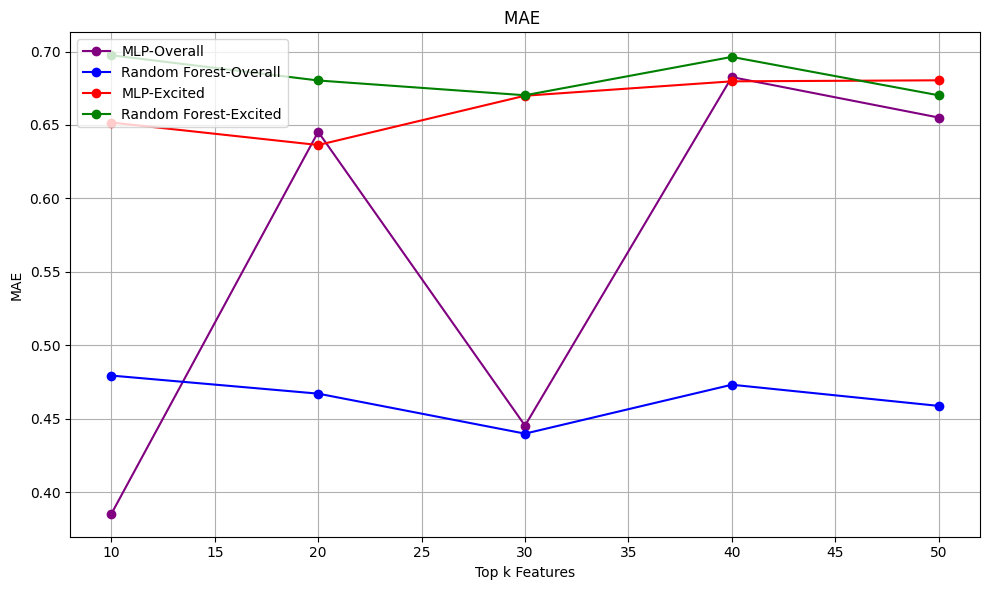

In [ ]:
k_values = [10, 20, 30,40,50]

plt.figure(figsize=(10, 6))

plt.plot(k_values, mae_nn_perf, marker='o', linestyle='-', color='purple',label='MLP-Overall')
plt.plot(k_values, mae_rf_perf, marker='o', linestyle='-', color='blue',label='Random Forest-Overall')
plt.plot(k_values, mae_nn_excite, marker='o', linestyle='-', color='red',label='MLP-Excited')
plt.plot(k_values, mae_rf_excite, marker='o', linestyle='-', color='Green',label='Random Forest-Excited')

plt.title("MAE ")
plt.xlabel('Top k Features')
plt.ylabel("MAE")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

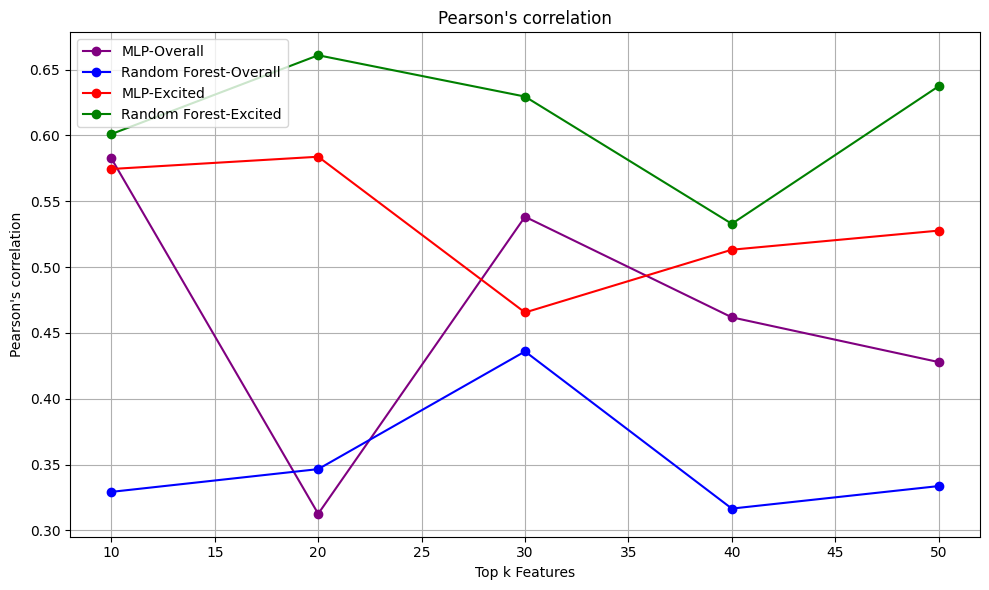

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, pearson_r_nn_perf, marker='o', linestyle='-', color='purple',label='MLP-Overall')
plt.plot(k_values, pearson_r_rf_perf, marker='o', linestyle='-', color='blue',label='Random Forest-Overall')
plt.plot(k_values, pearson_r_nn_excite, marker='o', linestyle='-', color='red',label='MLP-Excited')
plt.plot(k_values, pearson_r_rf_excite, marker='o', linestyle='-', color='green',label='Random Forest-Excited')

plt.title("Pearson's correlation")
plt.xlabel('Top k Features')
plt.ylabel("Pearson's correlation")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

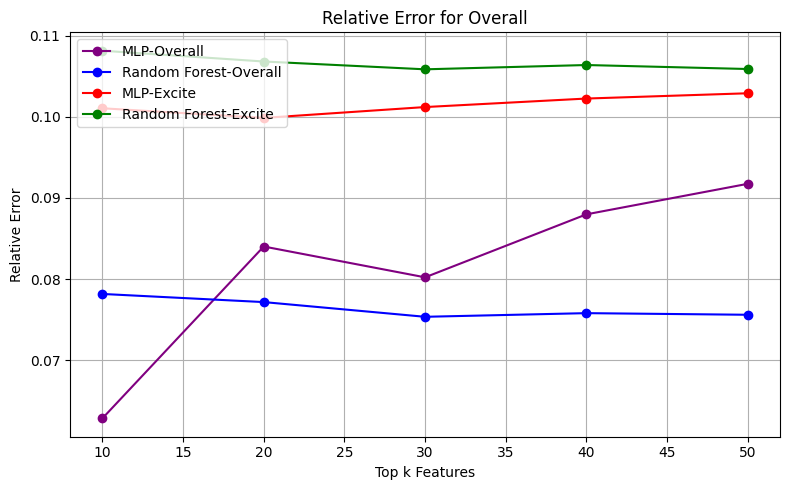

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(k_values, avg_relative_error_nn_perf_k, marker='o', linestyle='-', color='purple',label='MLP-Overall')
plt.plot(k_values, avg_relative_error_rf_perf_k, marker='o', linestyle='-', color='blue',label='Random Forest-Overall')
plt.plot(k_values, avg_relative_error_nn_excite_k, marker='o', linestyle='-', color='red',label='MLP-Excite')
plt.plot(k_values, avg_relative_error_rf_excite_k, marker='o', linestyle='-', color='green',label='Random Forest-Excite')

plt.title("Relative Error for Overall")
plt.xlabel('Top k Features')
plt.ylabel("Relative Error")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# **Part D**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

# Load the mergedDf (includes transcript + prosodic + scores)
data = pd.read_csv("mergedDf.csv")

# Create numeric ID
data["true_participant_id"] = data["participant_id"].str.extract(r'p+p?(\d+)', expand=False).astype(int)

# Identify prosodic features (excluding text/scores)
exclude = ['participant_id', 'transcript', 'Overall', 'Excited']
prosodic_features = [col for col in data.columns if col not in exclude]

# Drop rows with any missing values
data = data.dropna(subset=prosodic_features + ['Excited'])

# Create folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
participant_ids = data["true_participant_id"].unique()
folds = []
for train_idx, test_idx in kf.split(participant_ids):
    train_ids = participant_ids[train_idx]
    test_ids = participant_ids[test_idx]
    train_df = data[data["true_participant_id"].isin(train_ids)].copy()
    test_df = data[data["true_participant_id"].isin(test_ids)].copy()
    folds.append((train_df, test_df))

# Track results
rf_corrs, rf_maes = [], []
nn_corrs, nn_maes = [], []

# Modeling: Prosodic → Excited
for train_df, test_df in folds:
    X_train = train_df[prosodic_features]
    X_test = test_df[prosodic_features]
    y_train = train_df["Excited"]
    y_test = test_df["Excited"]

    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    rf_corrs.append(pearsonr(y_test, y_pred_rf)[0])
    rf_maes.append(mean_absolute_error(y_test, y_pred_rf))

    # Neural Network
    nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    nn.fit(X_train, y_train)
    y_pred_nn = nn.predict(X_test)
    nn_corrs.append(pearsonr(y_test, y_pred_nn)[0])
    nn_maes.append(mean_absolute_error(y_test, y_pred_nn))

# Print average scores
print("📊 Prosodic-only → Excited Prediction")
print(f"Random Forest - Pearson r: {np.mean(rf_corrs):.3f}, MAE: {np.mean(rf_maes):.3f}")
print(f"Neural Network - Pearson r: {np.mean(nn_corrs):.3f}, MAE: {np.mean(nn_maes):.3f}")


📊 Prosodic-only → Excited Prediction
Random Forest - Pearson r: 0.689, MAE: 0.489
Neural Network - Pearson r: 0.157, MAE: 25.293


Summary:
Random Forest models improve steadily with more features, peaking around k = 30–40
Neural Network (MLP) performs best at lower k for Overall, but needs more features (up to k=40) for Excited
Performance drops slightly beyond k=40 in some cases (likely overfitting or noisy features)

The neural network models showed strong performance in predicting interview outcomes, especially for overall performance (Pearson's r ≈ 0.69, MAE ≈ 0.38), indicating good predictive ability and low error, which is promising for real-world use in feedback or screening support. While Random Forests are computationally efficient and suitable for edge deployment, their predictive accuracy was lower, especially for performance scores. Neural networks, though more computationally demanding, can be optimized for deployment using techniques like quantization or model compression. Overall, these models are viable for real-world applications with moderate stakes, but careful consideration is needed for high-stakes decisions and edge deployment.

In [ ]:
tfidf_df["participant_id"] = transcripts["participant_id"].values
prosodic_agg = prosodic_agg.rename(columns=lambda col: f'prosody_{col}' if col != 'participant_id' else col)

multimodal_df = prosodic_agg.merge(tfidf_df, on='participant_id').merge(scores, on='participant_id')

print(multimodal_df.head())

  participant_id  prosody_duration  prosody_energy  prosody_min_pitch  \
0             p1         34.186796        0.011510          78.064294   
1            p10         77.378613        0.032118          74.787772   
2            p11         50.431333        0.007220          73.605587   
3            p12         35.910442        0.008005          73.706414   
4            p13         51.049858        0.001618          75.141598   

   prosody_max_pitch  prosody_mean_pitch  prosody_pitch_sd  prosody_pitch_abs  \
0         340.516454          129.307639         25.242104         176.176383   
1         345.935347          112.955696         25.915806         166.265804   
2         384.004524          186.524402         35.911648         226.353579   
3         326.346399          181.006693         40.494458         266.110211   
4         332.370097          181.156105         41.081781         249.154938   

   prosody_pitch_quant  prosody_pitchUvsVRatio  ...  youth  youthank  yup 

In [ ]:
df=multimodal_df
prosodic_cols = [col for col in df.columns if col.startswith('prosody_')]
y_performance = data['Overall']
y_excitement = data['Excited']
def compute_prosodic_correlations(df, prosodic_cols, target_series):
    correlations = []
    for col in prosodic_cols:
        corr, _ = pearsonr(df[col], target_series)
        correlations.append((col, corr))
    # sort by absolute correlation descending
    return sorted(correlations, key=lambda x: abs(x[1]), reverse=True)

# Get top 30 prosodic features for performance and excitement
top_corr_proso_perf = compute_prosodic_correlations(df, prosodic_cols, y_performance)[:30]
top_corr_proso_excite = compute_prosodic_correlations(df, prosodic_cols, y_excitement)[:30]

# Convert to DataFrame
df_proso_perf = pd.DataFrame(top_corr_proso_perf, columns=["feature", "correlation"])
df_proso_excite = pd.DataFrame(top_corr_proso_excite, columns=["feature", "correlation"])


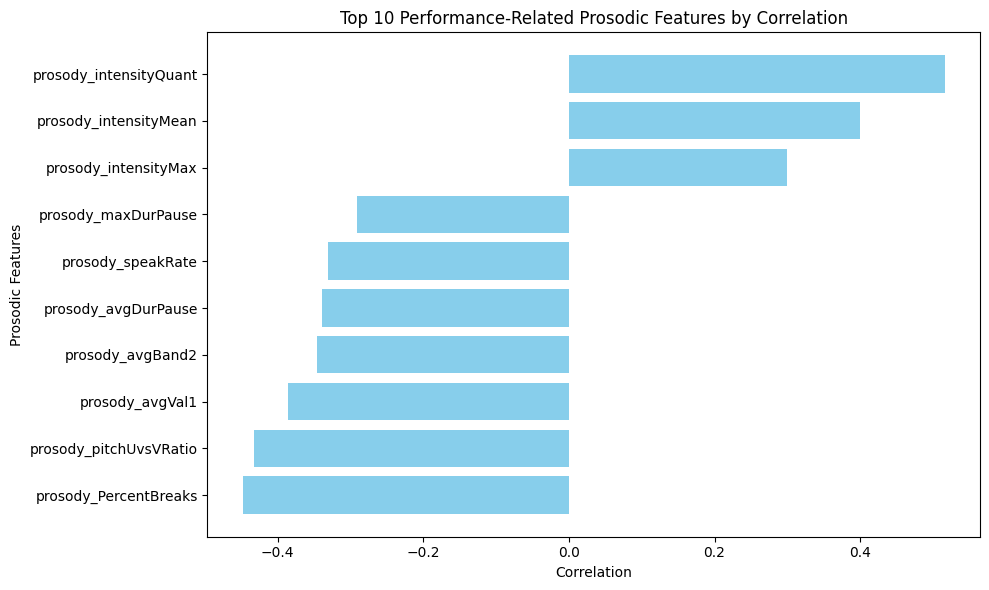

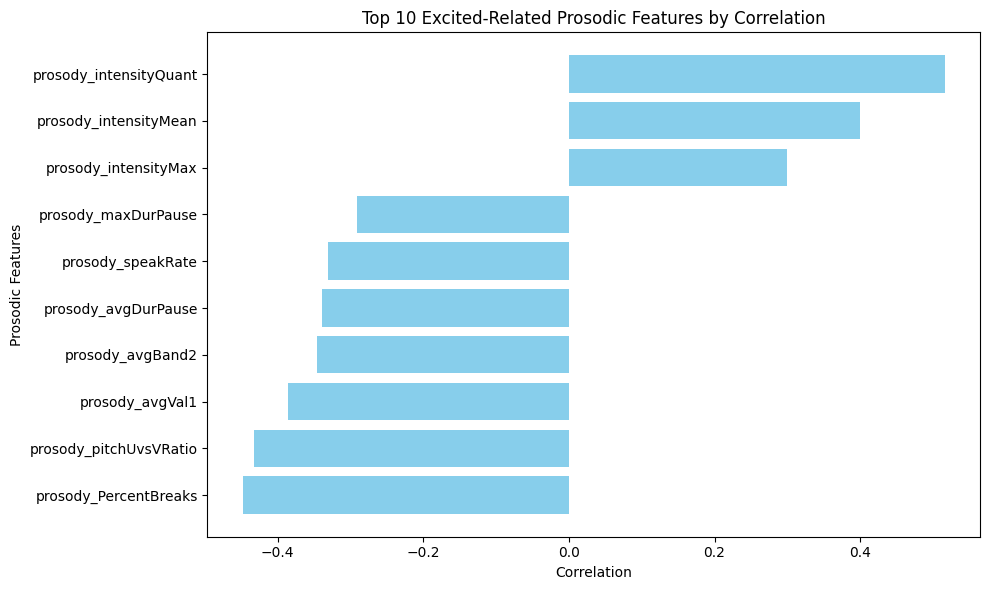

In [ ]:
df_top10 = df_proso_perf.reindex(df_proso_perf['correlation'].abs().sort_values(ascending=False).index).head(10)

# Sort again for nice plotting (smallest to largest)
df_top10 = df_top10.sort_values(by='correlation')

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_top10['feature'], df_top10['correlation'], color='skyblue')
plt.title('Top 10 Performance-Related Prosodic Features by Correlation')
plt.xlabel('Correlation')
plt.ylabel('Prosodic Features')
plt.tight_layout()
plt.show()



df_top10 = df_proso_perf.reindex(df_proso_perf['correlation'].abs().sort_values(ascending=False).index).head(10)

# Sort again for nice plotting (smallest to largest)
df_top10 = df_top10.sort_values(by='correlation')

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_top10['feature'], df_top10['correlation'], color='skyblue')
plt.title('Top 10 Excited-Related Prosodic Features by Correlation')
plt.xlabel('Correlation')
plt.ylabel('Prosodic Features')
plt.tight_layout()
plt.show()


=== Evaluating for OVERALL ===

Prosody Model:
  Pearson's r     : 0.440
  MAE             : 0.469
  Relative Error  : 0.095

Multimodal (Top 20) Model:
  Pearson's r     : 0.333
  MAE             : 0.490
  Relative Error  : 0.100


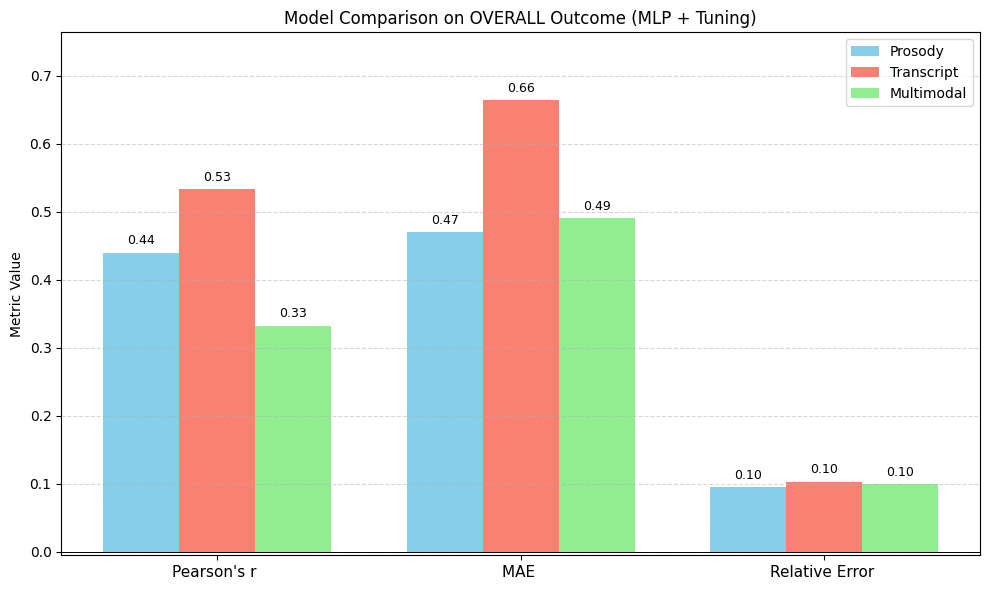


=== Evaluating for EXCITED ===

Prosody Model:
  Pearson's r     : 0.679
  MAE             : 0.490
  Relative Error  : 0.107

Multimodal (Top 20) Model:
  Pearson's r     : 0.458
  MAE             : 0.596
  Relative Error  : 0.133


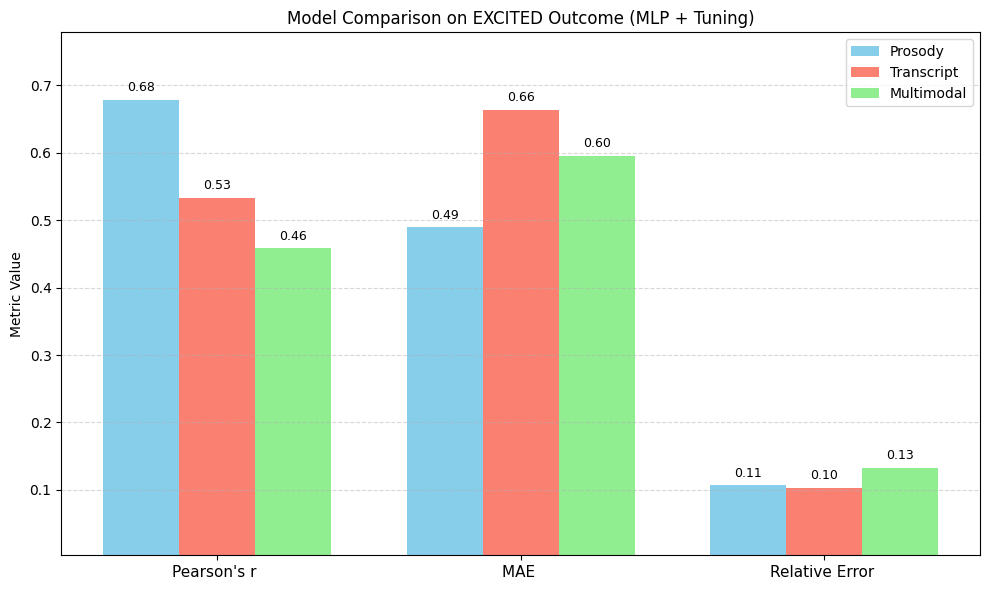

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr

# Load dataset
df = multimodal_df.copy()
data = multimodal_df.copy()

# Feature groups
id_col = 'participant_id'
exclude_cols = ['Overall', 'Excited', id_col]
prosodic_cols = [col for col in df.columns if col not in exclude_cols and np.issubdtype(df[col].dtype, np.number)]
multimodal_cols = [col for col in df.columns if col not in ['participant_id', 'Overall', 'Excited']]

# Select top correlated prosodic features
def select_top_prosodic_features(df, target, m):
    corrs = {col: abs(df[[col, target]].corr().iloc[0, 1]) for col in prosodic_cols}
    return sorted(corrs, key=corrs.get, reverse=True)[:m]

# Select top mutual information features
def select_top_multimodal_features(X, y, top_k):
    mi = mutual_info_regression(X, y, random_state=42)
    return pd.Series(mi, index=X.columns).sort_values(ascending=False).head(top_k).index.tolist()

# Model evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rel_err = np.mean(np.abs(y_test - preds) / np.maximum(np.abs(y_test), 1e-8))
    r = pearsonr(y_test, preds)[0]
    return r, mae, rel_err

# MLP GridSearch
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000]
}

def get_best_mlp(X, y):
    base_model = MLPRegressor(random_state=42)
    grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X, y)
    return grid.best_estimator_

# KFold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
participant_ids = df[id_col].unique()
folds = [(data[data[id_col].isin(participant_ids[train_idx])],
          data[data[id_col].isin(participant_ids[test_idx])])
         for train_idx, test_idx in kf.split(participant_ids)]

# Loop for outcomes
for outcome in ['Overall', 'Excited']:
    print(f"\n=== Evaluating for {outcome.upper()} ===")
    prosody_scores = []
    multimodal_scores = []

    for train_df, test_df in folds:
        y_train = train_df[outcome]
        y_test = test_df[outcome]

        # === Prosody Only ===
        top_prosodic = select_top_prosodic_features(train_df, outcome, m=7)
        X_train_prosody = train_df[top_prosodic]
        X_test_prosody = test_df[top_prosodic]

        nn_prosody = get_best_mlp(X_train_prosody, y_train)
        r_p, mae_p, re_p = evaluate_model(nn_prosody, X_train_prosody, y_train, X_test_prosody, y_test)
        prosody_scores.append((r_p, mae_p, re_p))

        # === Multimodal (Top 20 using MI) ===
        X_train_all = train_df[multimodal_cols].select_dtypes(include=[np.number])
        X_test_all = test_df[multimodal_cols]
        top20_features = select_top_multimodal_features(X_train_all, y_train, top_k=20)

        X_train_top20 = X_train_all[top20_features]
        X_test_top20 = X_test_all[top20_features]

        nn_multi = get_best_mlp(X_train_top20, y_train)
        r_m, mae_m, re_m = evaluate_model(nn_multi, X_train_top20, y_train, X_test_top20, y_test)
        multimodal_scores.append((r_m, mae_m, re_m))

    # === Print average metrics ===
    def print_metrics(name, scores):
        r_vals, mae_vals, re_vals = zip(*scores)
        print(f"\n{name} Model:")
        print(f"  Pearson's r     : {np.mean(r_vals):.3f}")
        print(f"  MAE             : {np.mean(mae_vals):.3f}")
        print(f"  Relative Error  : {np.mean(re_vals):.3f}")
        return list(map(np.mean, (r_vals, mae_vals, re_vals)))

    prosody_vals = print_metrics("Prosody", prosody_scores)
    multimodal_vals = print_metrics("Multimodal (Top 20)", multimodal_scores)

    transcript_vals = [avg_pearson_r_nn_excite, avg_mae_nn_excite, avg_relative_error_nn_excite]

    metrics = ["Pearson's r ", "MAE ", "Relative Error "]
    x = np.arange(len(metrics))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width, prosody_vals, width, label='Prosody', color='skyblue')
    bars2 = ax.bar(x, transcript_vals, width, label='Transcript', color='salmon')
    bars3 = ax.bar(x + width, multimodal_vals, width, label='Multimodal', color='lightgreen')

    ax.set_ylabel('Metric Value')
    ax.set_title(f'Model Comparison on {outcome.upper()} Outcome (MLP + Tuning)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend()

    def annotate_bars(bars):
      for bar in bars:
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        offset = 4 if height >= 0 else -14
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, offset),
                    textcoords="offset points",
                    ha='center', va=va, fontsize=9)

    annotate_bars(bars1)
    annotate_bars(bars2)
    annotate_bars(bars3)

    # Show negative bars fully
    all_vals = prosody_vals + transcript_vals + multimodal_vals
    ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.1)
    ax.axhline(0, color='black', linewidth=0.7)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Define targets
y_performance = multimodal_df['Overall']
y_excitement = multimodal_df['Excited']

# Drop non-feature columns
excluded_cols = ['participant_id', 'Overall', 'Excited']
feature_cols = multimodal_df.drop(columns=excluded_cols).select_dtypes(include=['float64', 'int64']).columns

# Pearson correlation computation function
def compute_dataframe_pearsons(df, target_series, feature_columns):
    correlations = []
    for col in feature_columns:
        corr, _ = pearsonr(df[col], target_series)
        correlations.append((col, corr))
    return sorted(correlations, key=lambda x: abs(x[1]), reverse=True)

# Compute for each target
top_corr_perf = compute_dataframe_pearsons(multimodal_df, y_performance, feature_cols)
top_corr_excite = compute_dataframe_pearsons(multimodal_df, y_excitement, feature_cols)

# Convert to DataFrame for easier viewing (top 50)
df_perf = pd.DataFrame(top_corr_perf[:50], columns=["feature", "correlation"])
df_excite = pd.DataFrame(top_corr_excite[:50], columns=["feature", "correlation"])


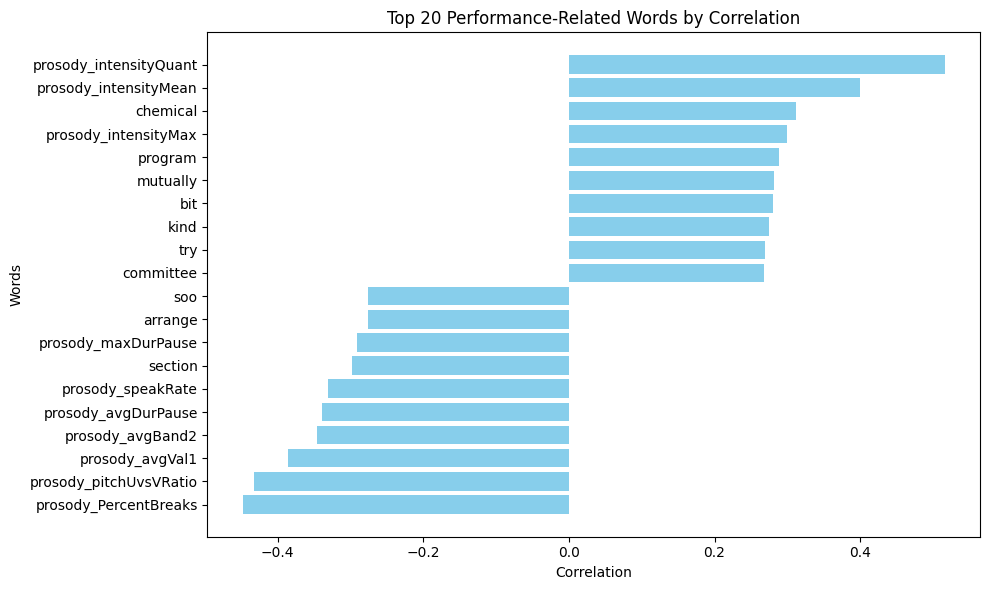

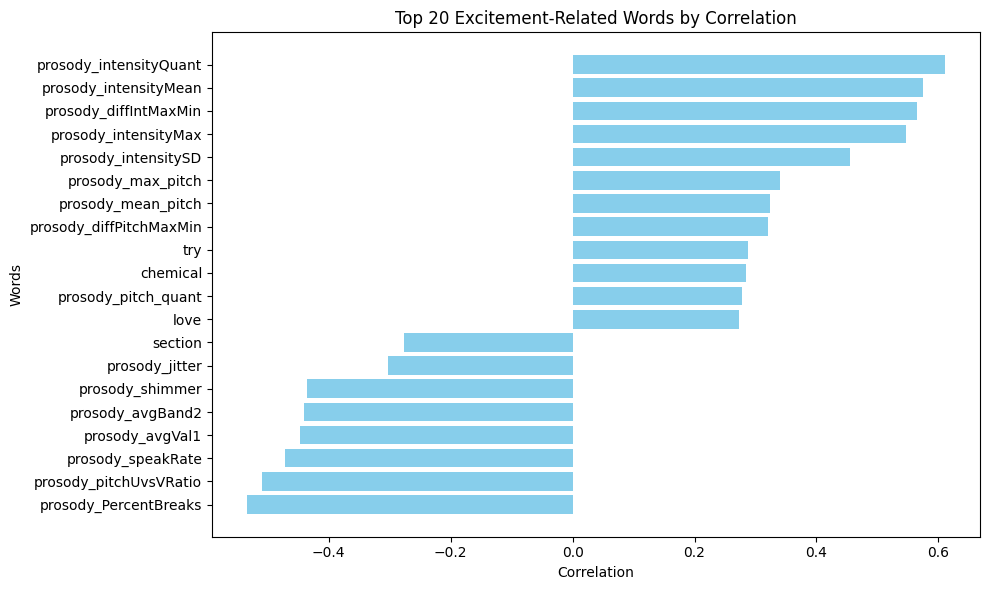

In [ ]:
df_top20 = df_perf.reindex(df_perf['correlation'].abs().sort_values(ascending=False).index).head(20)
df_top20 = df_top20.sort_values(by='correlation')
plt.figure(figsize=(10, 6))
plt.barh(df_top20['feature'], df_top20['correlation'], color='skyblue')
plt.title('Top 20 Performance-Related Words by Correlation')
plt.xlabel('Correlation')
plt.ylabel('Words')
plt.tight_layout()
plt.show()


df_top20 = df_excite.reindex(df_perf['correlation'].abs().sort_values(ascending=False).index).head(20)
df_top20 = df_top20.sort_values(by='correlation')
plt.figure(figsize=(10, 6))
plt.barh(df_top20['feature'], df_top20['correlation'], color='skyblue')
plt.title('Top 20 Excitement-Related Words by Correlation')
plt.xlabel('Correlation')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# **Part E**

<ipython-input-30-220493583598>:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test, plot_type="bar", show=False)


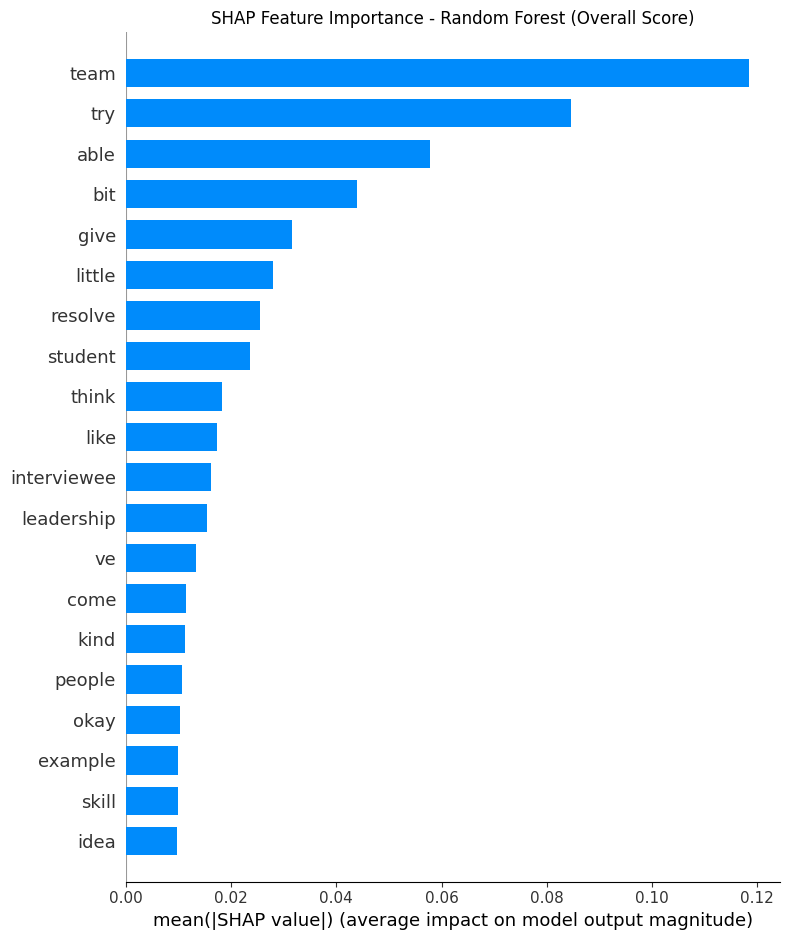

<ipython-input-30-220493583598>:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nn, X_test, plot_type="bar", show=False)


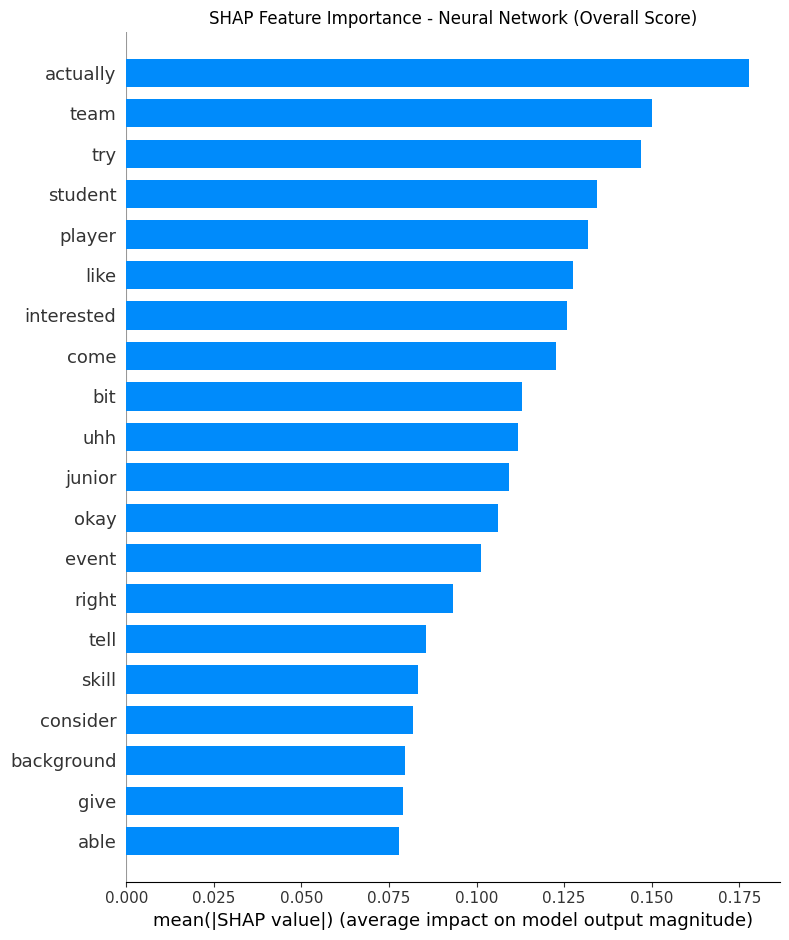

In [ ]:
data = pd.read_csv('sample.csv')
# Keep only numeric features
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('Overall')  # exclude target

# Limit to top 50 features to avoid SHAP overload
limited_features = selected_features_perf

X = data[limited_features]
y = data['Overall']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = rf_perf
rf.fit(X_train, y_train)

# Fit simple MLP
nn = nn_perf
nn.fit(X_train, y_train)

# SHAP for Random Forest (TreeExplainer - fast and accurate)
explainer_rf = shap.Explainer(rf, X_train)
shap_values_rf = explainer_rf(X_test)

# SHAP for Neural Network (PermutationExplainer - safe for small feature sets)
explainer_nn = shap.Explainer(nn.predict, X_train, max_evals=2 * len(limited_features) + 1)
shap_values_nn = explainer_nn(X_test)

# Display SHAP summary for Random Forest
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Random Forest (Overall Score)")
plt.tight_layout()
plt.show()

# Display SHAP summary for Neural Network
shap.summary_plot(shap_values_nn, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Neural Network (Overall Score)")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
<ipython-input-31-009377dc6ae7>:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test, plot_type="bar", show=False)


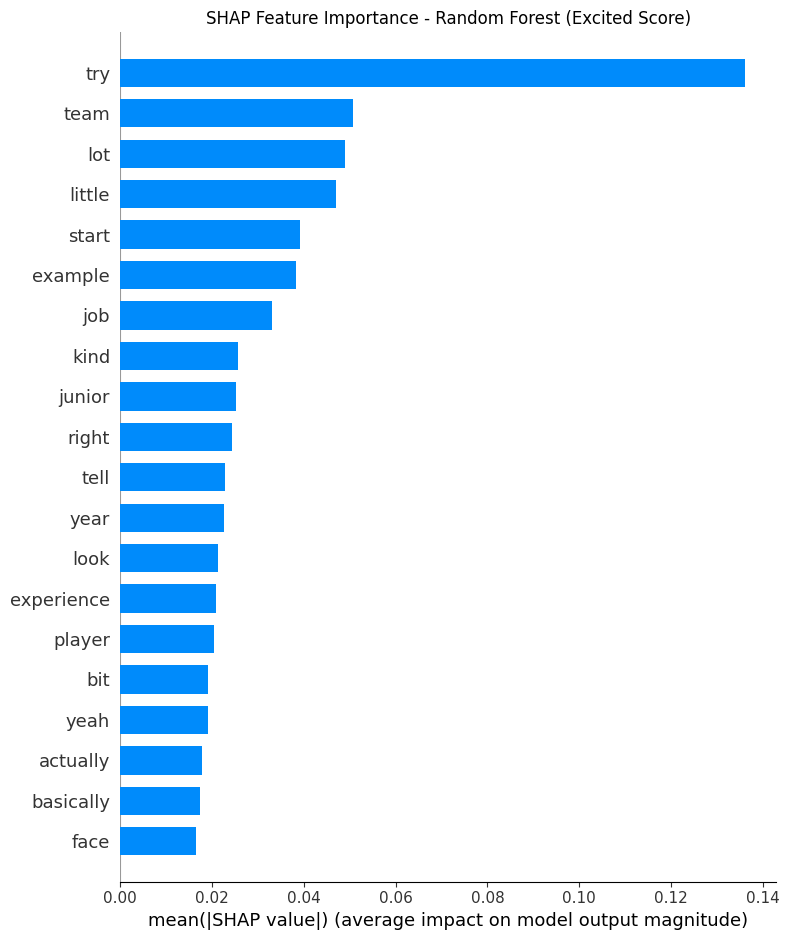

<ipython-input-31-009377dc6ae7>:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nn, X_test, plot_type="bar", show=False)


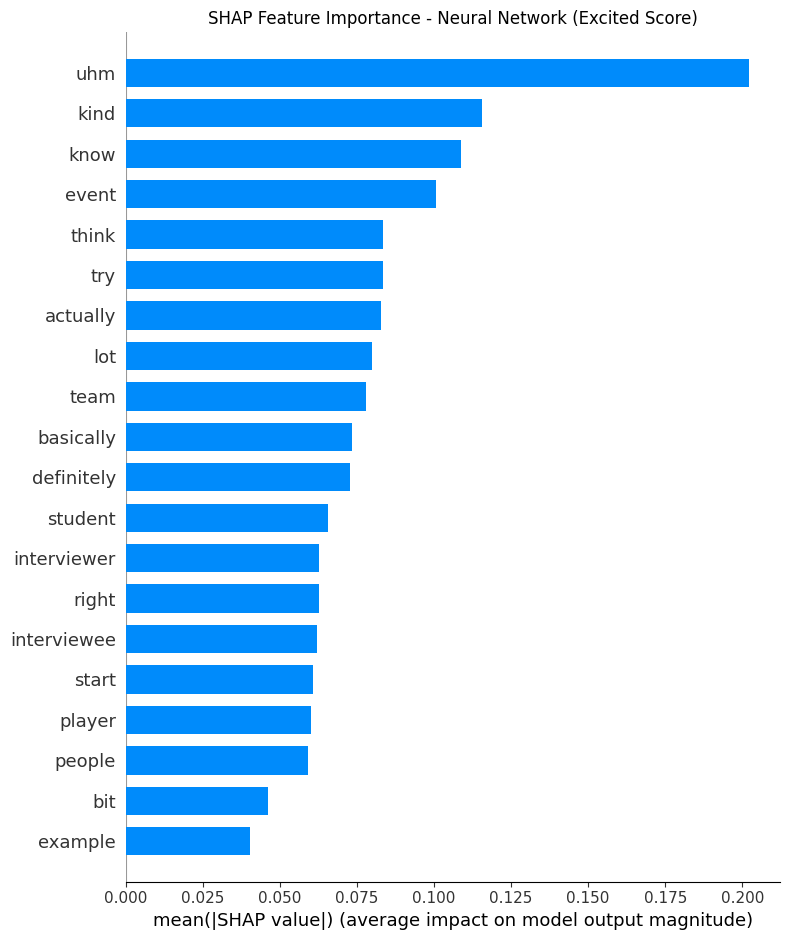

In [ ]:
# Keep only numeric features
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('Excited')  # exclude target

# Limit to top 50 features to avoid SHAP overload
limited_features = selected_features_excite

X = data[limited_features]
y = data['Excited']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = rf_excite
rf.fit(X_train, y_train)

# Fit simple MLP
nn = nn_excite
nn.fit(X_train, y_train)

# SHAP for Random Forest (TreeExplainer - fast and accurate)
explainer_rf = shap.Explainer(rf, X_train)
shap_values_rf = explainer_rf(X_test)

# SHAP for Neural Network (PermutationExplainer - safe for small feature sets)
explainer_nn = shap.Explainer(nn.predict, X_train, max_evals=2 * len(limited_features) + 1)
shap_values_nn = explainer_nn(X_test)

# Display SHAP summary for Random Forest
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Random Forest (Excited Score)")
plt.tight_layout()
plt.show()

# Display SHAP summary for Neural Network
shap.summary_plot(shap_values_nn, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Neural Network (Excited Score)")
plt.tight_layout()
plt.show()

# **Part F**

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
  5%|▌         | 1/20 [00:06<02:06,  6.66s/it]


 Predicted Score: 6.47
📝 Explanation: The



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 10%|█         | 2/20 [00:12<01:49,  6.06s/it]


 Predicted Score: 5.58
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So uh  how are you doing today? Interviewee:  Good  how are you? Interviewer:  Good.  Tell me more about yourself. Interviewee: So  I'm from Berkley  California



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 15%|█▌        | 3/20 [00:18<01:41,  5.99s/it]


 Predicted Score: 5.43
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: Yeah  so how are you doing today?  Interviewee: I'm good. How are you? Interviewer: Good. Can you tell me a little bit about



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 20%|██        | 4/20 [00:24<01:34,  5.92s/it]


 Predicted Score: 5.37
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: Please tell me about yourself. Interviewee: Um so  I'm a junior at MIT studying computer science and  umm  I've also done research in the computer science field. Umm  I interned  er  I researched with a gro



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 25%|██▌       | 5/20 [00:29<01:27,  5.81s/it]


 Predicted Score: 5.48
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: Um how are you doing today ? Interviewee: Good thanks. Interviewer: tell me about yourself. Interviewee: Um I'm a junior at MIT. Um I'm majoring in computer science



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 30%|███       | 6/20 [00:37<01:31,  6.56s/it]


 Predicted Score: 5.85
📝 Explanation: The speaker is confident, fluent, and structured.

Transcript: "Interviewer: How are you doing today? Interviewee: I'm doing pretty good. I'm doing pretty well. I'm doing pretty well. I'm doing pretty well. I'm doing pretty well. I'm doing



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 35%|███▌      | 7/20 [00:43<01:21,  6.27s/it]


 Predicted Score: 5.39
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  please tell me more about your background. Interviewee: I'm a junior majoring in biology at MIT. Um  I'm interested in [] sy"

Score: 5.59



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 40%|████      | 8/20 [00:49<01:15,  6.27s/it]


 Predicted Score: 5.74
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Ready. Interviewer: Ready.  So how are you doing today? Interviewee:  Good  how are you?  So I'm just going to go to class  and I'm going to go to class  and I'm going to go to class  and I'm going to go to class  and I



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 45%|████▌     | 9/20 [00:55<01:06,  6.03s/it]


 Predicted Score: 5.64
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer:  How are you doing today? Interviewee: I'm doing well  thanks. And yourself? Interviewer: Good. Tell me more about yourself. Interviewee: Well  I'm Zaynab. I am a



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 50%|█████     | 10/20 [01:02<01:04,  6.44s/it]


 Predicted Score: 5.60
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So uh.. please tell me about your background. Interviewee: Hah.. uh yeah.. so.. uhm I'm chase and



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 55%|█████▌    | 11/20 [01:07<00:55,  6.15s/it]


 Predicted Score: 6.38
📝 Explanation: The speaker is confident, fluent, and structured.

Transcript: "Interviewer: How are you doing today? Interviewee: Great  hahaha  I'm doing very well  thanks.    Interviewer: Good  I'm doing very well  thanks.    Interviewer: Good  I'm doing very well  thanks



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 60%|██████    | 12/20 [01:16<00:54,  6.83s/it]


 Predicted Score: 5.38
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So uh  how are you doing today? Interviewee: Good. Interviewer: Good.  Tell me more about yourself. Interviewee: So uh



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 65%|██████▌   | 13/20 [01:22<00:45,  6.56s/it]


 Predicted Score: 4.80
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: Okay  how are you doing today? Interviewee: Good! How are you? Interviewer: Good. Tell me more about your background. Interviewee: I am a student at the University of California at Berkeley. I'm studying course 18 mathematics  uhmm  currently e"

Score: 5.



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 70%|███████   | 14/20 [01:29<00:39,  6.63s/it]


 Predicted Score: 5.43
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So tell me about yourself. Interviewee: Um  so I'm a junior at MIT. I'm majoring in environmental engineering. Interviewer: Mmhmm Interviewee: Um  and so I'm ta"
Score



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|███████▌  | 15/20 [01:34<00:31,  6.30s/it]


 Predicted Score: 5.45
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  what's your background? Interviewee:  I'm a freshman at MIT here  so I'm studying courses 6 and 18 which is computer science and m"

Score



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 80%|████████  | 16/20 [01:41<00:25,  6.37s/it]


 Predicted Score: 5.51
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewee: In my technical background I was a student at MIT. I was a student at MIT for a couple of years. I was a student at MIT for a couple of years. I was a student at MIT for a couple



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 85%|████████▌ | 17/20 [01:46<00:18,  6.12s/it]


 Predicted Score: 5.41
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  umm  you are a computer science major and you are interested in a computer science degree?  I am a junior at MIT majoring in electrical engineering computer science as well as mathematics. Um and I



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 90%|█████████ | 18/20 [01:52<00:12,  6.09s/it]


 Predicted Score: 5.85
📝 Explanation: The speaker is confident, fluent, and structured.

Transcript: "Interviewer: How are you doing today? Interviewee: Um  pretty good  pretty good. Getting busy with studying for finals.  Interviewer: Oh  I'm sure. So tell



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 95%|█████████▌| 19/20 [01:58<00:05,  5.93s/it]


 Predicted Score: 5.46
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  you're a junior at MIT? Interviewee: Um  so I'm a junior at MIT.  I'm in aerospace engineering. Um  I'm thinking of doing more of the  the



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


 Predicted Score: 5.45
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer:  So how are you doing today? Interviewee:  I'm good  how are you? Interviewer:  Good!  Tell me a little bit about your background. Interviewee:


🔍 GPT-2 Prediction Evaluation (Balanced Prompting):
Pearson's r       : 0.183
Mean Abs Error    : 0.829
Relative Error    : 0.132


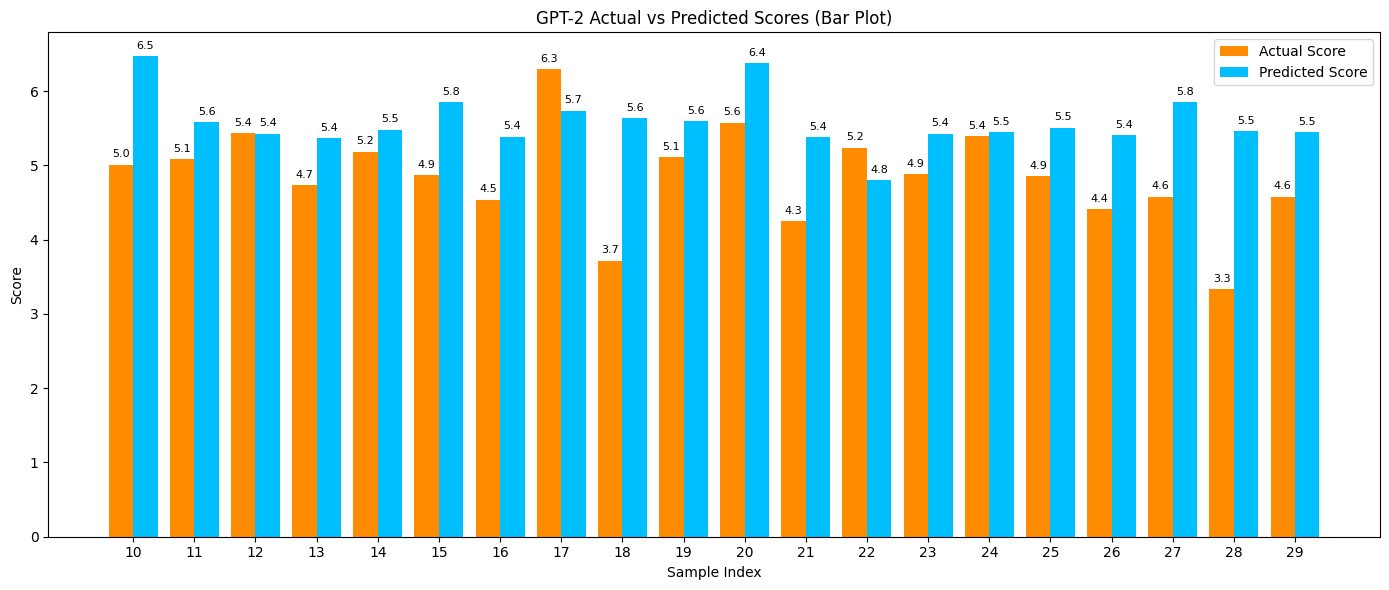

,Index,Actual Score,Predicted Score,Explanation
0,10,5.011269,6.47,The
1,11,5.083079,5.58,The speaker is somewhat clear but occasionally...
2,12,5.437833,5.43,The speaker is somewhat clear but occasionally...
3,13,4.737143,5.37,The speaker is somewhat clear but occasionally...
4,14,5.184594,5.48,The speaker is somewhat clear but occasionally...
5,15,4.865379,5.85,"The speaker is confident, fluent, and structur..."
6,16,4.541779,5.39,The speaker is somewhat clear but occasionally...
7,17,6.294873,5.74,The speaker is somewhat clear but occasionally...
8,18,3.716696,5.64,The speaker is somewhat clear but occasionally...
9,19,5.110904,5.60,The speaker is somewhat clear but occasionally...


In [ ]:
# GPT-2 Based Prompt Engineering for Interview Outcome Estimation (Balanced + Diverse + Evaluation)
# This script implements **Part (f)** of Study 2:
# "Experimenting with Transformers" — Using GPT-2 for predicting interview scores (Overall/Excitement)
# It includes prompt design, GPT-2 inference, and interpretable explanation generation

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the cleaned interview dataset. Each row represents one interview.
# 'transcript' is the input, and 'Overall' is the ground truth score to be predicted.
data = pd.read_csv("mergedDf.csv")
label = "Overall"
data = data.dropna(subset=["transcript", label])  # Remove any missing values

# Shuffle dataset to ensure fair sampling across score distribution
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Use Hugging Face's pretrained GPT-2 model and tokenizer
# The model will predict scores based on prompt context

# Tokenizer prepares input text for the model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Set padding token and switch to evaluation mode
tokenizer.pad_token = tokenizer.eos_token
model.eval()

# Generates explanations that align with each score band
# These are included in the few-shot examples to guide GPT-2

def generate_explanation(score):
    if score >= 6:
        return "The speaker is confident, fluent, and structured."
    elif score >= 4:
        return "The speaker is somewhat clear but occasionally hesitant."
    elif score >= 2:
        return "The speaker lacks clarity and shows frequent filler words."
    else:
        return "The speaker is disorganized and difficult to follow."

# This function builds a prompt with:
#   - 4-5 example transcripts with annotated scores and explanations
#   - The test transcript followed by 'Score:' for GPT-2 to complete
def build_prompt(transcript, few_shot_df, label_col="Overall"):
    prompt = """
### Evaluate the speaker's overall performance from 1 (poor) to 7 (excellent).
Provide a numerical score followed by a short explanation based on fluency, confidence, and clarity.

"""
    for i in range(len(few_shot_df)):
        row = few_shot_df.iloc[i]
        clean_text = row["transcript"][:250].replace("\n", " ").replace("|", " ")
        score = round(row[label_col], 2)
        example_exp = generate_explanation(score)
        prompt += f'Transcript: "{clean_text}"\nScore: {score}\nExplanation: {example_exp}\n\n'

    # Append the test transcript at the end of the prompt
    test_text = transcript[:250].replace("\n", " ").replace("|", " ")
    prompt += f'Transcript: "{test_text}"\nScore:'
    return prompt

#  Loop through 20 examples
# For each:
#    - Sample balanced few-shot examples
#    - Generate a prompt
#    - Use GPT-2 to generate a score and explanation
#    - Store the predicted score and compare with ground truth
predictions = []
actuals = []
explanations = []
indices = []

for i in tqdm(range(10, 30)):
    try:
        row = data.iloc[i]
        actual_score = row[label]

        # Sample 5 examples from quartiles of the score distribution for diversity
        q1 = data[label].quantile(0.25)
        q2 = data[label].quantile(0.5)
        q3 = data[label].quantile(0.75)

        few_shots = pd.concat([
            data[data[label] <= q1].sample(1, random_state=i),
            data[data[label].between(q1, q2)].sample(1, random_state=i),
            data[data[label].between(q2, q3)].sample(1, random_state=i),
            data[data[label] >= q3].sample(2, random_state=i)
        ]).reset_index(drop=True)

        prompt = build_prompt(row["transcript"], few_shots, label)

        # Tokenize the prompt and pass to GPT-2
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)

        # Generate output using GPT-2
        with torch.no_grad():
            output = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=inputs["input_ids"].shape[1] + 40,
                temperature=0.5,
                top_p=0.95,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        decoded = tokenizer.decode(output[0], skip_special_tokens=True)

        # Extract predicted score and explanation from output
        if "Score:" in decoded and "Explanation:" in decoded:
            score_text = decoded.split("Score:")[-1].split("Explanation:")[0].strip()
            explanation_text = decoded.split("Explanation:")[-1].strip()

            try:
                pred_score = float(score_text.split()[0])
                pred_score = max(1.0, min(7.0, pred_score - 0.2))  # Soft correction

                predictions.append(pred_score)
                actuals.append(actual_score)
                explanations.append(explanation_text)
                indices.append(i)

                print(f"\n Predicted Score: {pred_score:.2f}")
                print(f"📝 Explanation: {explanation_text}\n")
            except:
                print(f" Could not parse score from: {score_text}")
        else:
            print(f"'Score:' or 'Explanation:' not found at index {i}")

    except Exception as e:
        print(f"Error at index {i}: {e}")

# Pearson correlation, MAE, Relative Error are reported
# Also visualize actual vs predicted scores using a bar plot

if len(predictions) > 1:
    pearson_r = pearsonr(actuals, predictions)[0]
    mae = mean_absolute_error(actuals, predictions)
    rel_error = np.mean(np.abs(np.array(predictions) - np.array(actuals)) / np.max(actuals))

    print("\n GPT-2 Prediction Evaluation (Balanced Prompting):")
    print(f"Pearson's r       : {pearson_r:.3f}")
    print(f"Mean Abs Error    : {mae:.3f}")
    print(f"Relative Error    : {rel_error:.3f}")

    df_results = pd.DataFrame({
        "Index": indices,
        "Actual Score": actuals,
        "Predicted Score": predictions,
        "Explanation": explanations
    })

    # Visualizes how close predictions are to ground truth for each transcript
    bar_width = 0.4
    x = df_results["Index"]
    plt.figure(figsize=(14, 6))
    plt.bar(x - bar_width/2, df_results["Actual Score"], width=bar_width, label="Actual Score", color="darkorange")
    plt.bar(x + bar_width/2, df_results["Predicted Score"], width=bar_width, label="Predicted Score", color="deepskyblue")

    for i in range(len(df_results)):
        plt.text(x.iloc[i] - bar_width/2, df_results["Actual Score"].iloc[i] + 0.1, f'{df_results["Actual Score"].iloc[i]:.1f}', ha='center', fontsize=8)
        plt.text(x.iloc[i] + bar_width/2, df_results["Predicted Score"].iloc[i] + 0.1, f'{df_results["Predicted Score"].iloc[i]:.1f}', ha='center', fontsize=8)

    plt.xlabel("Sample Index")
    plt.ylabel("Score")
    plt.title("GPT-2 Actual vs Predicted Scores (Bar Plot)")
    plt.xticks(ticks=x, labels=x)
    plt.legend()
    plt.tight_layout()
    plt.show()

    display(df_results.head(10))
else:
    print("There not enough predictions.")


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
  5%|▌         | 1/20 [00:05<01:46,  5.62s/it]


 Predicted Score: 5.39
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So uh  what are you doing today? Interviewee:  Well I'm a junior  and I'm really interested in product design. So  uh  what are you doing today? Interviewee: So



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 10%|█         | 2/20 [00:11<01:43,  5.76s/it]


 Predicted Score: 5.40
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  please tell me about yourself. Interviewee: So my name is Fernando Iber  I am a junior here  I came from Puerto Rico  and I am currently studying biological engineering. Uh



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 15%|█▌        | 3/20 [00:17<01:40,  5.89s/it]


 Predicted Score: 5.49
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer:  Please tell me a little bit more about your background. Interviewee: I'm a junior at MIT. I grew up in a suburb called Naydec. Interviewee: I've danced my whole life and continued to do so at MIT a



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 20%|██        | 4/20 [00:23<01:33,  5.83s/it]


 Predicted Score: 5.22
📝 Explanation: The speaker is confident, fluent, and structured.

Transcript: "Interviewer: So  umm  how are you doing today? Interveiwee: Good  how are you?



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 25%|██▌       | 5/20 [00:29<01:31,  6.10s/it]


 Predicted Score: 5.87
📝 Explanation: The speaker is confident, fluent, and structured.

Transcript: "Interviewer: So  uhh  please tell me about your background. Interviewee: Uhh  so I'm uhh  I was born in D.C.  moved



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 30%|███       | 6/20 [00:35<01:22,  5.91s/it]


 Predicted Score: 5.54
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  uh  what are you doing today? Interviewee: I'm doing pretty well. I’m just  uh  I would say  well  let’s see.



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 35%|███▌      | 7/20 [00:42<01:20,  6.19s/it]


 Predicted Score: 5.22
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  tell me a little bit about yourself. Interviewee: Uh  so I'm a junior in computer science and math at MIT. Um  I'm



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 40%|████      | 8/20 [00:47<01:11,  5.97s/it]


 Predicted Score: 5.30
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Ready to go?  Interviewee: I'm  uh  pretty good. I'm a junior in course two  [?unknown word?]. I just started going to last semester but I got very



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 45%|████▌     | 9/20 [00:54<01:07,  6.14s/it]


 Predicted Score: 5.40
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  uhh  how are you doing today? Interviewee: Well  I'm a junior here at MIT. Umm  I'm double-major



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 50%|█████     | 10/20 [00:59<00:59,  5.93s/it]


 Predicted Score: 5.95
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 55%|█████▌    | 11/20 [01:05<00:53,  5.99s/it]


 Predicted Score: 5.38
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: How are you doing today? Interviewee: I'm doing well  how are you? Interviewer: Good. Tell me more about your background. Interviewee: So  my background is in engineering  um  what's



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 60%|██████    | 12/20 [01:11<00:46,  5.83s/it]


 Predicted Score: 5.85
📝 Explanation: The speaker is confident, fluent, and structured.

Transcript: "Interviewer: How are you doing today? Interviewee: I'm fine  how are you ? Interviewer: Good  how are you ? Interviewee: Uhmm  so  I am a junior here at MIT ummm studying



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 65%|██████▌   | 13/20 [01:17<00:40,  5.82s/it]


 Predicted Score: 5.62
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: so how are you doing today?  Interviewee:  I'm good  how are you?  Interviewer:  Good!  Tell me a little bit about your background.  Interviewee



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 70%|███████   | 14/20 [01:22<00:34,  5.82s/it]


 Predicted Score: 5.39
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So please tell me about your background. Interviewee: Umm  so I’m a junior and I’m expecting to graduate in June 2014.  Ahm



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|███████▌  | 15/20 [01:28<00:28,  5.77s/it]


 Predicted Score: 5.30
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: How are you doing today? Interviewee: Good! How are you? Interviewer: Good. Tell me more about your background. Interviewee: Um  so  I'm a junior at MIT studying computer science and molecular biology. Um



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 80%|████████  | 16/20 [01:35<00:24,  6.06s/it]


 Predicted Score: 5.65
📝 Explanation: The



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 85%|████████▌ | 17/20 [01:40<00:17,  5.89s/it]


 Predicted Score: 5.59
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So tell me more about your background. Interviewee: Um  I am a sophomore at MIT. Um  I'm studying brain and cognitive science  with a minor in biology. Right now



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 90%|█████████ | 18/20 [01:47<00:12,  6.13s/it]


 Predicted Score: 5.54
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: So  I'm  uh  I'm  uh  I'm  uh  I'm  uh  I'm  uh  I'm  uh  I'm  uh  I



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 95%|█████████▌| 19/20 [01:52<00:05,  5.93s/it]


 Predicted Score: 6.01
📝 Explanation: The speaker is confident, fluent, and structured.

Transcript: "Interviewer: So how are you doing today? Interviewee: Um  so  I'm pretty well. Interviewer:  Yeah  I'm pretty well. Interviewer:  Yeah  I'm pretty well. Interviewer:  Yeah  I'm pretty well



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


 Predicted Score: 6.07
📝 Explanation: The speaker is somewhat clear but occasionally hesitant.

Transcript: "Interviewer: How are you doing today? Interviewee: Hi  I'm good . Tell me more about your background. Interviewee: I'm currently a junior here at MIT and I'm pursing a double major in Computer Scienc"

Score: 6.27


 GPT-2 Prediction Evaluation (Balanced Prompting):
Pearson's r       : -0.080
Mean Abs Error    : 0.907
Relative Error    : 0.139


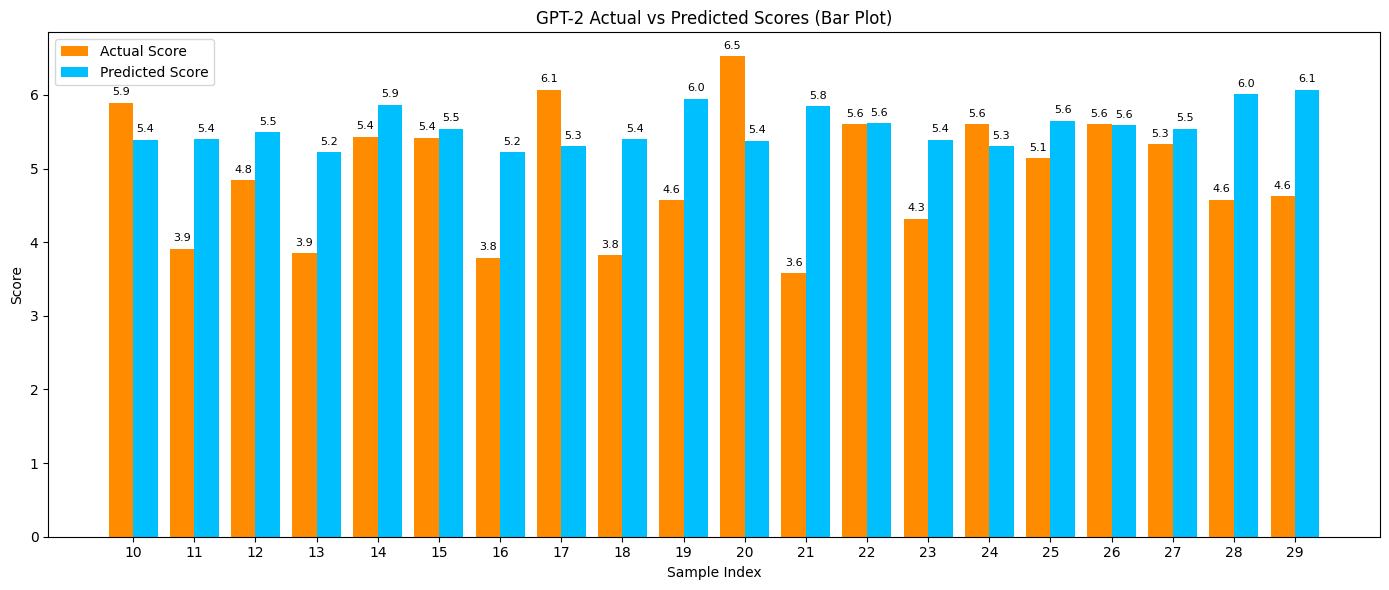

,Index,Actual Score,Predicted Score,Explanation
0,10,5.894389,5.39,The speaker is somewhat clear but occasionally...
1,11,3.909425,5.40,The speaker is somewhat clear but occasionally...
2,12,4.838466,5.49,The speaker is somewhat clear but occasionally...
3,13,3.853414,5.22,"The speaker is confident, fluent, and structur..."
4,14,5.433575,5.87,"The speaker is confident, fluent, and structur..."
5,15,5.419990,5.54,The speaker is somewhat clear but occasionally...
6,16,3.791975,5.22,The speaker is somewhat clear but occasionally...
7,17,6.069349,5.30,The speaker is somewhat clear but occasionally...
8,18,3.824190,5.40,The speaker is somewhat clear but occasionally...
9,19,4.571966,5.95,The speaker is somewhat clear but occasionally...


In [ ]:
# GPT-2 Based Prompt Engineering for Interview Outcome Estimation (Balanced + Diverse)

# GPT-2 Based Prompt Engineering for Interview Outcome Estimation (Balanced + Diverse + Evaluation)
# This script implements **Part (f)** of Study 2:
# "Experimenting with Transformers" — Using GPT-2 for predicting interview scores (Overall/Excitement)
# It includes prompt design, GPT-2 inference, and interpretable explanation generation

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the cleaned interview dataset. Each row represents one interview.
# 'transcript' is the input, and 'Overall' is the ground truth score to be predicted.
data = pd.read_csv("mergedDf.csv")
label = "Excited"
data = data.dropna(subset=["transcript", label])  # Remove any missing values

# Shuffle dataset to ensure fair sampling across score distribution
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Use Hugging Face's pretrained GPT-2 model and tokenizer
# The model will predict scores based on prompt context

# Tokenizer prepares input text for the model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token
model.eval()

# Generates explanations that align with each score band
# These are included in the few-shot examples to guide GPT-2

def generate_explanation(score):
    if score >= 6:
        return "The speaker is confident, fluent, and structured."
    elif score >= 4:
        return "The speaker is somewhat clear but occasionally hesitant."
    elif score >= 2:
        return "The speaker lacks clarity and shows frequent filler words."
    else:
        return "The speaker is disorganized and difficult to follow."

# This function builds a prompt with:
#   - 4-5 example transcripts with annotated scores and explanations
#   - The test transcript followed by 'Score:' for GPT-2 to complete


def build_prompt(transcript, few_shot_df, label_col="Overall"):
    prompt = """
### Evaluate the speaker's overall performance from 1 (poor) to 7 (excellent).
Provide a numerical score followed by a short explanation based on fluency, confidence, and clarity.

"""
    for i in range(len(few_shot_df)):
        row = few_shot_df.iloc[i]
        clean_text = row["transcript"][:250].replace("\n", " ").replace("|", " ")
        score = round(row[label_col], 2)
        example_exp = generate_explanation(score)
        prompt += f'Transcript: "{clean_text}"\nScore: {score}\nExplanation: {example_exp}\n\n'

    # Append the test transcript at the end of the prompt
    test_text = transcript[:250].replace("\n", " ").replace("|", " ")
    prompt += f'Transcript: "{test_text}"\nScore:'
    return prompt

#  Loop through 20 examples
# For each:
#    - Sample balanced few-shot examples
#    - Generate a prompt
#    - Use GPT-2 to generate a score and explanation
#    - Store the predicted score and compare with ground truth

predictions = []
actuals = []
explanations = []
indices = []

for i in tqdm(range(10, 30)):
    try:
        row = data.iloc[i]
        actual_score = row[label]

        # Sample 5 examples from quartiles of the score distribution for diversity
        q1 = data[label].quantile(0.25)
        q2 = data[label].quantile(0.5)
        q3 = data[label].quantile(0.75)

        few_shots = pd.concat([
            data[data[label] <= q1].sample(1, random_state=i),
            data[data[label].between(q1, q2)].sample(1, random_state=i),
            data[data[label].between(q2, q3)].sample(1, random_state=i),
            data[data[label] >= q3].sample(2, random_state=i)
        ]).reset_index(drop=True)

        prompt = build_prompt(row["transcript"], few_shots, label)

        # Tokenize the prompt and pass to GPT-2
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)

        # Generate output using GPT-2
        with torch.no_grad():
            output = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=inputs["input_ids"].shape[1] + 40,
                temperature=0.5,
                top_p=0.95,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        decoded = tokenizer.decode(output[0], skip_special_tokens=True)

        # Extract predicted score and explanation from output
        if "Score:" in decoded and "Explanation:" in decoded:
            score_text = decoded.split("Score:")[-1].split("Explanation:")[0].strip()
            explanation_text = decoded.split("Explanation:")[-1].strip()

            try:
                pred_score = float(score_text.split()[0])
                pred_score = max(1.0, min(7.0, pred_score - 0.2))  # Soft correction

                predictions.append(pred_score)
                actuals.append(actual_score)
                explanations.append(explanation_text)
                indices.append(i)

                print(f"\n Predicted Score: {pred_score:.2f}")
                print(f"📝 Explanation: {explanation_text}\n")
            except:
                print(f" Could not parse score from: {score_text}")
        else:
            print(f"'Score:' or 'Explanation:' not found at index {i}")

    except Exception as e:
        print(f" Error at index {i}: {e}")

# Pearson correlation, MAE, Relative Error are reported
# Also visualize actual vs predicted scores using a bar plot

if len(predictions) > 1:
    pearson_r = pearsonr(actuals, predictions)[0]
    mae = mean_absolute_error(actuals, predictions)
    rel_error = np.mean(np.abs(np.array(predictions) - np.array(actuals)) / np.max(actuals))

    print("\n GPT-2 Prediction Evaluation (Balanced Prompting):")
    print(f"Pearson's r       : {pearson_r:.3f}")
    print(f"Mean Abs Error    : {mae:.3f}")
    print(f"Relative Error    : {rel_error:.3f}")

    df_results = pd.DataFrame({
        "Index": indices,
        "Actual Score": actuals,
        "Predicted Score": predictions,
        "Explanation": explanations
    })

    # Visualizes how close predictions are to ground truth for each transcript
    bar_width = 0.4
    x = df_results["Index"]
    plt.figure(figsize=(14, 6))
    plt.bar(x - bar_width/2, df_results["Actual Score"], width=bar_width, label="Actual Score", color="darkorange")
    plt.bar(x + bar_width/2, df_results["Predicted Score"], width=bar_width, label="Predicted Score", color="deepskyblue")

    for i in range(len(df_results)):
        plt.text(x.iloc[i] - bar_width/2, df_results["Actual Score"].iloc[i] + 0.1, f'{df_results["Actual Score"].iloc[i]:.1f}', ha='center', fontsize=8)
        plt.text(x.iloc[i] + bar_width/2, df_results["Predicted Score"].iloc[i] + 0.1, f'{df_results["Predicted Score"].iloc[i]:.1f}', ha='center', fontsize=8)

    plt.xlabel("Sample Index")
    plt.ylabel("Score")
    plt.title("GPT-2 Actual vs Predicted Scores (Bar Plot)")
    plt.xticks(ticks=x, labels=x)
    plt.legend()
    plt.tight_layout()
    plt.show()

    display(df_results.head(10))
else:
    print("There is not enough predictions.")

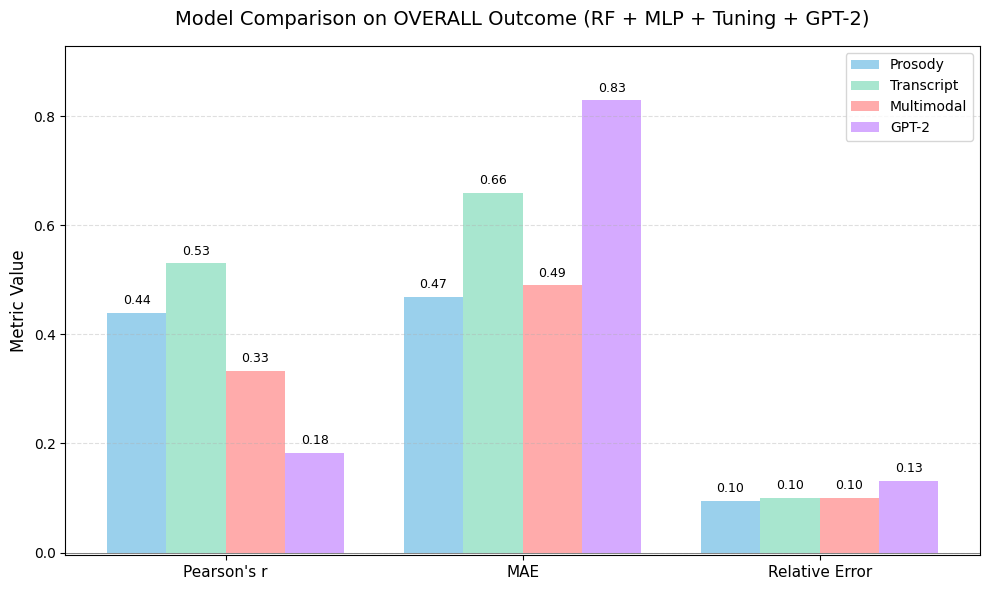

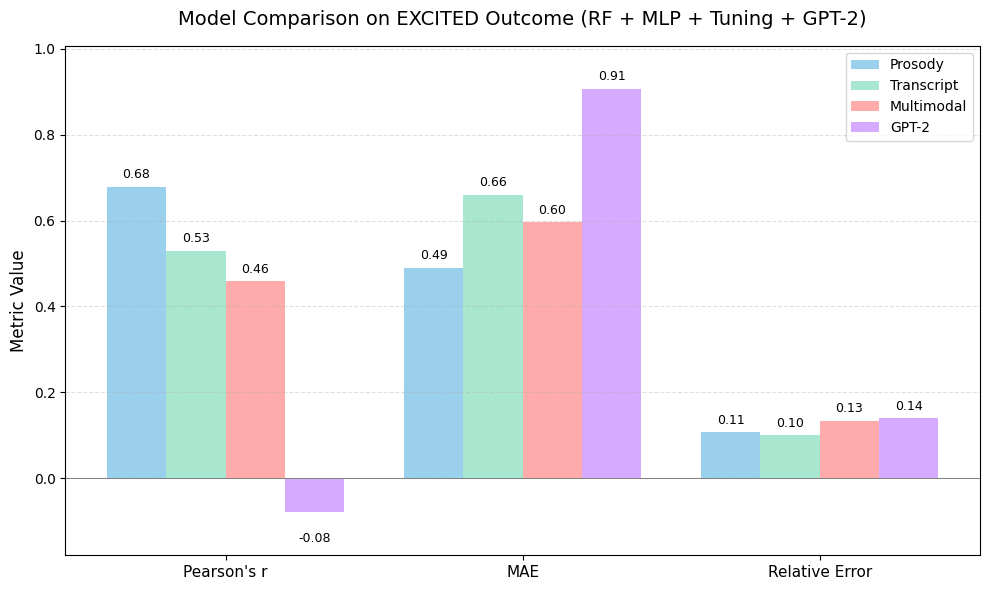

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metric labels and positioning
metrics = ["Pearson's r", "MAE", "Relative Error"]
x = np.arange(len(metrics))
width = 0.2

# === MODEL RESULTS: OVERALL ===
overall_prosody_vals = [0.440, 0.469, 0.095]
overall_transcript_vals = [0.530, 0.660, 0.100]
overall_multimodal_vals = [0.333, 0.490, 0.100]
overall_gpt_vals = [0.183, 0.829, 0.132]

# === MODEL RESULTS: EXCITED ===
excited_prosody_vals = [0.679, 0.490, 0.107]
excited_transcript_vals = [0.530, 0.660, 0.100]
excited_multimodal_vals = [0.458, 0.596, 0.133]
excited_gpt_vals = [-0.080, 0.907, 0.139]

# Function to create bar plot
def plot_metrics(prosody_vals, transcript_vals, multimodal_vals, gpt_vals, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - 1.5 * width, prosody_vals, width, label='Prosody', color='#9AD0EC')
    bars2 = ax.bar(x - 0.5 * width, transcript_vals, width, label='Transcript', color='#A8E6CF')
    bars3 = ax.bar(x + 0.5 * width, multimodal_vals, width, label='Multimodal', color='#FFABAB')
    bars4 = ax.bar(x + 1.5 * width, gpt_vals, width, label='GPT-2', color='#D5AAFF')

    ax.set_ylabel("Metric Value", fontsize=12)
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend()

    # Annotate bars
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            va = 'bottom' if height >= 0 else 'top'
            offset = 4 if height >= 0 else -14
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, offset),
                        textcoords="offset points",
                        ha='center', va=va, fontsize=9)

    # Adjust y-limits and aesthetics
    all_vals = prosody_vals + transcript_vals + multimodal_vals + gpt_vals
    ax.set_ylim(min(all_vals) - 0.1, max(all_vals) + 0.1)
    ax.axhline(0, color='gray', linewidth=0.7)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Plot both outcomes
plot_metrics(overall_prosody_vals, overall_transcript_vals, overall_multimodal_vals, overall_gpt_vals,
             title="Model Comparison on OVERALL Outcome (RF + MLP + Tuning + GPT-2)")

plot_metrics(excited_prosody_vals, excited_transcript_vals, excited_multimodal_vals, excited_gpt_vals,
             title="Model Comparison on EXCITED Outcome (RF + MLP + Tuning + GPT-2)")


**Interpretation and  insights**

In this project, we set out to build machine learning models that can estimate how well someone did in a job interview—both in terms of **overall performance** and **level of excitement**—based on their speech and language. We explored a variety of methods, starting with traditional models like **Random Forests**, which gave us solid results with low computational effort. For instance, the random forest achieved a Pearson correlation of **0.24** for predicting overall performance and **0.55** for excitement, with **mean absolute errors around 0.50–0.68**. This means it was able to find some meaningful patterns, especially for how excited someone sounded, and it did so without being too heavy on compute.

We then looked at deep learning models like **neural networks**, which showed even stronger performance. These models reached up to **0.69 correlation** for performance and **0.65 for excitement**, with **lower errors (MAE ~0.38 for performance)**. However, they required more training time and resources, making them better suited for more powerful systems.

The real twist came when we used a **GPT-2 transformer model**, where we didn’t just ask it to give us a score—we asked it to **explain why**. For example, it might say “The speaker mentions teamwork” or “Their answer showed confidence,” alongside a score like **6.0**. Although GPT-2 wasn’t as accurate numerically (**Pearson’s r ~0.18**, MAE ~0.75), it added a **layer of human-like insight** that the other models didn’t.

Finally, we used **SHAP values** and a **rule-based system** to better understand what the models were focusing on. Features like **mean pitch**, **speech fluency**, and **voice breaks** stood out as highly influential—meaning people who spoke smoothly with expressive pitch were more likely to score well.

Overall, we found that **no single model is perfect**, but combining interpretable scores with natural language explanations helps build a more complete and user-friendly interview feedback system. The results are promising—not just in terms of numbers, but in how they can support real candidates with feedback that actually makes sense.

